# Tech Challenge 4
**Autora:** Glynda Calazans

**RM:** 357444

**Grupo:** 40

**Turma:** 6DTAT


---




**Objetivos do Projeto:**


1. **Coleta de dados:** Obter dados hist√≥ricos do pre√ßo do petr√≥leo brent.

2. **Constru√ß√£o de um modelo preditivo:** Criar um modelo de Machine Learning para prever o pre√ßo di√°rio do petr√≥leo.

3. **Desenvolvimento do dashboard:** Criar um dashboard interativo para visualizar as varia√ß√µes do pre√ßo do petr√≥leo e os insights gerados.

4. **Storytelling:** Demonstrar todo o processo, desde a captura e tratamento dos dados at√© a modelagem, visualiza√ß√£o e insights.

5. **Gera√ß√£o de insights:** Apresentar pelo menos quatro insights relevantes sobre a varia√ß√£o do pre√ßo do petr√≥leo, considerando fatores como situa√ß√µes geopol√≠ticas, crises econ√¥micas e demanda global por energia.

6. **Deploy do modelo:** Desenvolver um plano de produ√ß√£o e criar um MVP funcional utilizando Streamlit.

8. **Apresenta√ß√£o final:** Elaborar um v√≠deo de at√© 5 minutos explicando o desenvolvimento do projeto.

## Bibliotecas & M√©tricas


In [48]:
! pip install scikit-learn xgboost tqdm
!pip install pmdarima
!pip install ipeadatapy

import pandas as pd
import numpy as np

# Visualiza√ß√£o de Dados
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf

import seaborn as sns
sns.color_palette("light:b", as_cmap=True)

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# Coleta de Dados (Yahoo)
import yfinance as yf
import ipeadatapy as idpy

# Modelagem e Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#An√°lise de Tendencia, Sazonalidade e Res√≠duo
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose


In [49]:
#MODELOS
import statsmodels.api as sm
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### M√©tricas de avalia√ß√£o dos modelos

In [50]:
#M√©tricas para avaliar os modelos
from sklearn.metrics import r2_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

# Fun√ß√µes de Avalia√ß√£o
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape

def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

from scipy import stats

### Perfumaria

In [51]:
# Definir o estilo global usando plt.rcParams para os gr√°ficos
plt.rcParams.update({
    'figure.figsize': (18, 5),  # Tamanho padr√£o das figuras
    'axes.facecolor': '#fdfefe',  # Fundo branco para os gr√°ficos
    'axes.edgecolor': 'none',  # Remove o contorno (bordas dos gr√°ficos)
    'grid.color': 'lightgray',  # Cor clara para o grid
    'grid.linestyle': '--',  # Estilo tracejado para o grid
    'grid.linewidth': 0.5,  # Espessura do grid
    'lines.linewidth': 1,  # Espessura padr√£o das linhas (corresponde √† padroniza√ß√£o escolhida)
    'lines.color': '#607d8b',  # Cor padr√£o das linhas
    'legend.frameon': True,  # Contorno da legenda
    'axes.spines.top': False,  # Remove o contorno superior
    'axes.spines.right': False,  # Remove o contorno direito
    'axes.spines.left': False,  # Remove o contorno esquerdo
    'axes.spines.bottom': False  # Remove o contorno inferior
})

#Filtro para avisos
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore")

## Dataset


As colunas do dataset tratado do Ibovespa s√£o as seguintes:

- **Data**: Dia em que o dado foi obtido
- **Fechamento**: Indica o valor da a√ß√£o do √∫ltimo fechamento do dia
- **Abertura**: Indica o primeiro valor da a√ß√£o do dia
- **M√°xima**: Cota√ß√£o m√°xima do dia
- **Minima**: Cota√ß√£o m√≠nima do dia
- **Volume (M)**: Indica o fluxo de negocia√ß√µes que ocorreram no dia em Milh√£o.

Colunas complementares para realizar an√°lises:
- **Ano**: Ano em que o dado foi obtido
- **M√™s**: M√™s em que o dado foi obtido
- **Dia da Semana (dia_semana)**: Dia da semana em que o dado foi obtido (O Brent utiliza o fuso hor√°rio de londres e n√£o funciona aos finais de semana).



### Yahoo! Finan√ßas (Brent)

No Yahoo Finance, o Brent √© listado pelo ticker BZ=F, permitindo o acompanhamento de sua cota√ß√£o em tempo real, al√©m de an√°lises hist√≥ricas e t√©cnicas.

In [52]:
# @title
# Baixar dados do Brent
df = yf.download('BZ=F', start='2007-08-01', end='2025-02-28', progress=False)

# Tratamento
# df.drop(columns=['Adj Close'], inplace=True)
df.columns = ['fechamento', 'max', 'min', 'abertura', 'volume']

# Arredondar valores num√©ricos para 2 casas decimais
colunas_numericas = ['fechamento', 'max', 'min', 'abertura', 'volume']
df[colunas_numericas] = df[colunas_numericas].round(2)

# Adicionar colunas de data
# Garantir que o √≠ndice √© um objeto datetime
df.index = pd.to_datetime(df.index)

# Adicionar coluna de ano
df['ano'] = df.index.year

# Adicionar coluna de m√™s
df['m√™s'] = df.index.month

# Adicionar coluna de dia da semana em portugu√™s
dias_semana = {
    0: 'segunda',
    1: 'ter√ßa',
    2: 'quarta',
    3: 'quinta',
    4: 'sexta',
    5: 's√°bado',
    6: 'domingo'
}
df['dia_semana'] = df.index.dayofweek.map(dias_semana)

# Visualizar o DataFrame
df

fechamento    max    min  abertura  volume   ano  m√™s dia_semana
Date                                                                        
2007-08-01       75.35  77.06  74.86     77.00    3930  2007    8     quarta
2007-08-02       75.76  76.21  74.27     75.22    6180  2007    8     quinta
2007-08-03       74.75  76.00  74.53     75.39    4387  2007    8      sexta
2007-08-06       71.17  74.60  70.87     74.54    7201  2007    8    segunda
2007-08-07       71.80  72.01  70.56     70.80    6775  2007    8      ter√ßa
...                ...    ...    ...       ...     ...   ...  ...        ...
2025-02-21       74.43  76.75  74.21     76.56   28100  2025    2      sexta
2025-02-24       74.78  74.91  73.91     73.91   17858  2025    2    segunda
2025-02-25       73.02  75.25  72.70     74.89   19080  2025    2      ter√ßa
2025-02-26       72.53  73.34  72.39     73.14   11916  2025    2     quarta
2025-02-27       74.04  74.26  72.48     72.69    7925  2025    2     quinta

[4371 rows x 8 columns]

In [53]:
# Obter informa√ß√µes sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4371 entries, 2007-08-01 to 2025-02-27
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fechamento  4371 non-null   float64
 1   max         4371 non-null   float64
 2   min         4371 non-null   float64
 3   abertura    4371 non-null   float64
 4   volume      4371 non-null   int64  
 5   ano         4371 non-null   int32  
 6   m√™s         4371 non-null   int32  
 7   dia_semana  4371 non-null   object 
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 273.2+ KB


In [54]:
# Estat√≠sticas descritivas do dataset
df.describe().round(2)

fechamento      max      min  abertura    volume      ano      m√™s
count     4371.00  4371.00  4371.00   4371.00   4371.00  4371.00  4371.00
mean        78.61    79.58    77.58     78.61  18717.29  2015.93     6.58
std         24.23    24.32    24.08     24.21  16669.55     5.08     3.45
min         19.33    21.27    16.00     19.56      0.00  2007.00     1.00
25%         60.26    61.20    59.26     60.33   1341.00  2012.00     4.00
50%         76.67    77.59    75.65     76.67  19096.00  2016.00     7.00
75%         99.94   101.28    98.46     99.94  31335.50  2020.00    10.00
max        146.08   147.43   144.27    146.08  92049.00  2025.00    12.00

In [55]:
df.tail() #verifica se o dado esta ordenado e o ultimo √© a ultima data mesmo

fechamento    max    min  abertura  volume   ano  m√™s dia_semana
Date                                                                        
2025-02-21       74.43  76.75  74.21     76.56   28100  2025    2      sexta
2025-02-24       74.78  74.91  73.91     73.91   17858  2025    2    segunda
2025-02-25       73.02  75.25  72.70     74.89   19080  2025    2      ter√ßa
2025-02-26       72.53  73.34  72.39     73.14   11916  2025    2     quarta
2025-02-27       74.04  74.26  72.48     72.69    7925  2025    2     quinta

## 1. An√°lise Explorat√≥ria de Dados (AED)


### 1.1 An√°lise Geral do Cen√°rio

**Brent Crude**

O Brent Crude √© um dos principais benchmarks globais para a precifica√ß√£o do petr√≥leo, sendo utilizado como refer√™ncia nos mercados da Europa, √Åsia e √Åfrica. Seu nome vem do campo petrol√≠fero Brent, descoberto em 1971 pela Shell no Mar do Norte. A partir da d√©cada de 1980, com o crescimento da produ√ß√£o na regi√£o, o Brent passou a ser amplamente utilizado como refer√™ncia de pre√ßos no mercado internacional.

Atualmente, seus contratos futuros s√£o negociados na ICE Futures Europe, onde servem como base para a precifica√ß√£o de grande parte do petr√≥leo comercializado mundialmente. Seu pre√ßo reflete a oferta e demanda global por energia e √© fortemente influenciado por fatores como instabilidade geopol√≠tica, decis√µes da OPEP e estoques de petr√≥leo nos EUA. Assim, o Brent funciona como um indicador do equil√≠brio entre produ√ß√£o e consumo de petr√≥leo no cen√°rio global.

 **Periodo Analisado**

A partir dos dados di√°rios de fechamento do Brent, extra√≠dos do Yaho, para o per√≠odo de agosto de 2007 (1¬∫ dado no yahoo) a fevereiro de 2025, foi constru√≠da uma s√©rie temporal que captura a intensa volatilidade do √≠ndice e sua sensibilidade a eventos internos e externos. A evolu√ß√£o do Brent ao longo dos √∫ltimos 18 anos pode ser visualizada no Gr√°fico 1, que servir√° como ponto de partida para a nossa an√°lise.

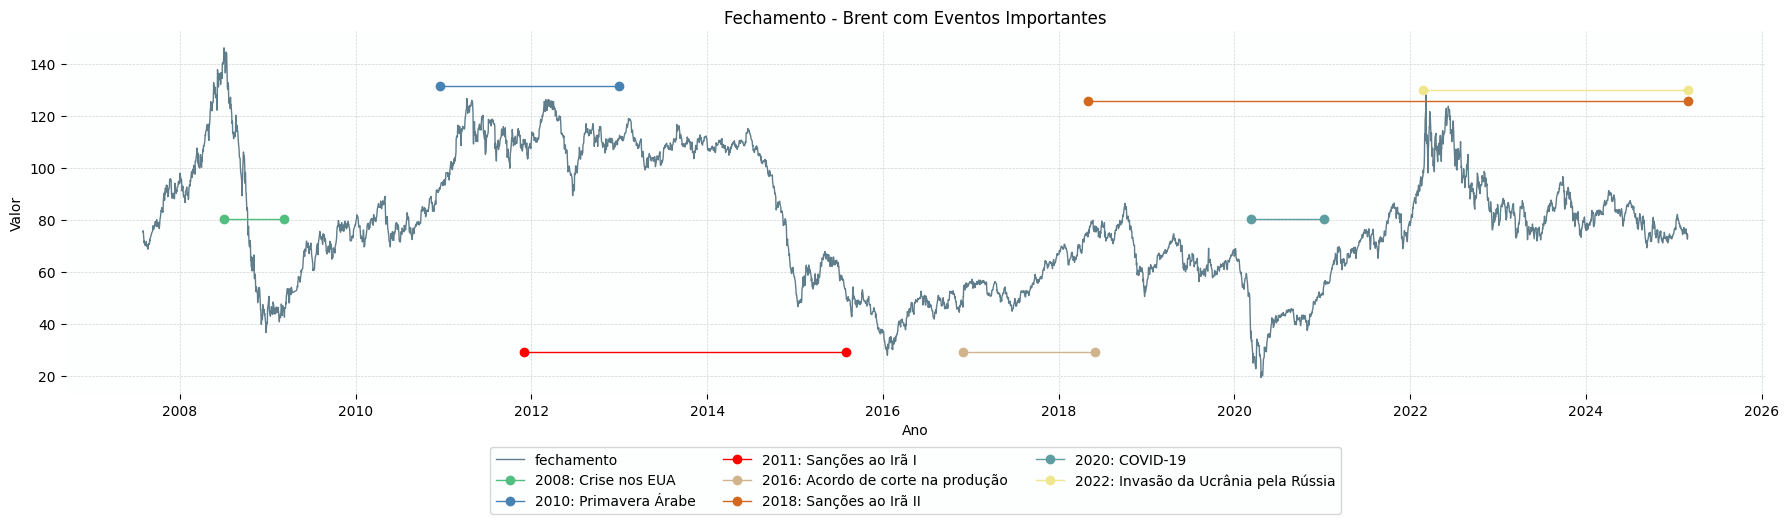

In [56]:
# @title

def plot_series_with_events(data, column, events, bars_data=None, title='', ylabel='', xlabel=''):

    ## Gr√°fico Principal (BRENT)
    plt.plot(data.index, data[column], label=column, color='#607d8b')

    # Definir intervalo de 2 anos no eixo X
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Define o intervalo de 2 anos
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato do r√≥tulo do eixo X

    ## Ilustrar Eventos que causam impacto

    # Cores e posi√ß√µes dos eventos
    colors = ['#52be80', '#4682B4', 'red','#D2B48C', '#D2691E', '#5F9EA0', '#F0E68C']
    y_positions = [max(data[column]) * 0.55, max(data[column]) * 0.9, max(data[column]) * 0.2,
                   max(data[column]) * 0.2, max(data[column]) * 0.86, max(data[column]) * 0.55, max(data[column]) * 0.89]

    # Adicionando os eventos ao gr√°fico
    for i, (inicio, fim, evento) in enumerate(zip(events['In√≠cio'], events['Fim'], events['Eventos'])):
        plt.plot([inicio, fim], [y_positions[i]] * 2, marker='o', color=colors[i], label=evento)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
    # Ajustar o layout para acomodar a legenda na parte inferior
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Ajuste este valor conforme necess√°rio
    plt.show()

    # Criar DataFrame para os eventos
eventos = pd.DataFrame({
        'Eventos': ['2008: Crise nos EUA','2010: Primavera √Årabe','2011: San√ß√µes ao Ir√£ I','2016: Acordo de corte na produ√ß√£o', '2018: San√ß√µes ao Ir√£ II','2020: COVID-19','2022: Invas√£o da Ucr√¢nia pela R√∫ssia'],
        'In√≠cio': [pd.Timestamp('2008-07-01'), pd.Timestamp('2010-12-17'),pd.Timestamp('2011-12-01'),pd.Timestamp('2016-12-01'),pd.Timestamp('2018-05-01'), pd.Timestamp('2020-03-11'), pd.Timestamp('2022-02-24')],
        'Fim': [pd.Timestamp('2009-03-09'), pd.Timestamp('2012-12-31'),pd.Timestamp('2015-07-30'),pd.Timestamp('2018-06-01'),pd.Timestamp('2025-03-01'), pd.Timestamp('2021-01-06'), pd.Timestamp('2025-03-01')]
})
# Usar a fun√ß√£o para plotar a s√©rie do fechamento do BRENT com eventos
plot_series_with_events(data=df, column='fechamento', events=eventos,
                            title='Fechamento - Brent com Eventos Importantes',
                            ylabel='Valor', xlabel='Ano')


**Gr√°fico 1:** S√©rie temporal do Brent (2007-2025) com destaque para os principais eventos que influenciaram sua trajet√≥ria.

 A an√°lise da s√©rie permite identificar per√≠odos de alta e baixa volatilidade, bem como a rela√ß√£o entre eventos espec√≠ficos e as oscila√ß√µes do √≠ndice. Em geral, a s√©rie apresenta uma tend√™ncia de crescimento geral ao longo do per√≠odo, com quedas expressivas nos anos de 2008,2015, 2016 e 2020.


**REVER: Observa-se tamb√©m uma sazonalidade anual, com aumentos mais concentrados no meio de cada ciclo e quedas mais acentuadas ao final (Gr√°fico 11). A decomposi√ß√£o da s√©rie temporal torna esses padr√µes ainda mais evidentes.**

#### 1.1.1 Eventos que causaram grande impacto no Brent
Saiba mais em detalhes:



**Crises e Recess√µes:**

*   **2008 - 2009** - **Crise financeira global** (setembro de 2008 a meados de 2009): A crise financeira de 2008, catalisada pela fal√™ncia do Lehman Brothers em 15 de setembro de 2008 e uma s√©rie de colapsos no mercado imobili√°rio dos Estados Unidos, gerou uma crise de confian√ßa nos mercados globais. Esse evento impactou significativamente o Brent que caiu de cerca de $145 (julho de 2008) para $36 (dezembro de 2008) devido √† recess√£o global e queda na demanda.

*   **2020 - 2021** - **Pandemia de COVID-19**: A pandemia, declarada oficialmente pela OMS em 11 de mar√ßo de 2020, provocou uma das maiores crises globais recentes. O colapso da demanda levou o Brent a $19 (abril/2020), um dos n√≠veis mais baixos da hist√≥ria.



**Conflitos Geopol√≠ticos:**

*   **2010 - 2012** - **Primavera √Årabe**: Foi uma onda de protestos, revoltas e revolu√ß√µes que come√ßou em dezembro de 2010 na Tun√≠sia e se espalhou por v√°rios pa√≠ses do Oriente M√©dio e Norte da √Åfrica, impulsionada por demandas por democracia, direitos civis e melhores condi√ß√µes econ√¥micas. Como resultado, os pre√ßos foram elevados acima de $120.

*   **2011-2012 e 2018** - **San√ß√µes ao Ir√£**: Ocorreram principalmente devido ao seu programa nuclear, que gerou preocupa√ß√µes internacionais sobre a possibilidade de desenvolvimento de armas at√¥micas. Os Estados Unidos, a Uni√£o Europeia e a ONU impuseram restri√ß√µes econ√¥micas e comerciais para pressionar o pa√≠s a limitar suas atividades nucleares. Al√©m disso, o Ir√£ enfrentou san√ß√µes por seu apoio a grupos considerados terroristas, viola√ß√µes de direitos humanos e instabilidade geopol√≠tica no Oriente M√©dio. Algumas dessas san√ß√µes foram parcialmente suspensas ap√≥s o Acordo Nuclear de 2015 (JCPOA), mas muitas foram restabelecidas em 2018, quando os EUA se retiraram do acordo. Estas estri√ß√µes ao petr√≥leo iraniano causaram oscila√ß√µes acima de $100.

*  **2022 - 2025** - **Invas√£o da Ucr√¢nia pela R√∫ssia**: Em 24 de fevereiro de 2022, ap√≥s anos de tens√µes desde a anexa√ß√£o da Crimeia em 2014. A R√∫ssia alegou motivos de seguran√ßa, mas a comunidade internacional condenou a a√ß√£o como uma viola√ß√£o da soberania ucraniana, impondo san√ß√µes severas. O conflito resultou em milhares de mortes, crise energ√©tica global e cont√≠nuos embates militares.A guerra impulsionou o Brent acima de $130, devido ao temor de restri√ß√µes ao petr√≥leo russo.

**Decis√µes da Organiza√ß√£o dos Pa√≠ses Exportadores de Petr√≥leo (OPEP+):**

* **2016 - 2018** - **Acordos da OPEP para corte na produ√ß√£o**: Em setembro e novembro, a OPEP fechou dois acordos para reduzir a produ√ß√£o de petr√≥leo, buscando conter o excesso de oferta e impulsionar os pre√ßos no mercado global.Como resultado houve um aumento gradual nos pre√ßos do petr√≥leo, que subiram de cerca de $30 por barril em 2016 para mais de $70 por barril em 2018. A redu√ß√£o na oferta ajudou a equilibrar o mercado, embora os pre√ßos n√£o tenham se estabilizado totalmente, com flutua√ß√µes ainda vis√≠veis.

* **2023 - 2024** - **OPEP e OPEP+ reduzem produ√ß√£o**: Em novembro, a OPEP e seus aliados anunciaram um corte de quase 2,2 milh√µes de barris por dia para aumentar os pre√ßos do petr√≥leo, com in√≠cio em janeiro de 2024. Ap√≥s o an√∫ncio, o pre√ßo do Brent subiu 1,5%, mas essa alta n√£o se manteve devido √† demanda mais fraca, especialmente na China e EUA. Em setembro de 2024, o pre√ßo caiu para menos de $70 por barril, o que n√£o ocorria desde novembro de 2021.

### 1.2 An√°lise do conjunto de dados

A an√°lise explorat√≥ria dos dados do Brent √© uma etapa fundamental para a compreen√ß√£o da natureza da s√©rie temporal e identifica√ß√£o de padr√µes relevantes para a modelagem. Por meio da an√°lise univariada e bivariada √© poss√≠vel observar a sensibilidade do √≠ndice a eventos e fatores temporais.

* A **an√°lise univariada** evidenciou que eventos excepcionais, como crises, elevam a m√©dia dos fechamentos, mesmo com a moda significativamente mais baixa, indicando o impacto de outliers na alta dispers√£o dos dados.
* A **an√°lise bivariada revelou** uma correla√ß√£o positiva (0.74) entre o volume e o ano, indicando que o volume de negocia√ß√µes vem aumentando de forma consistente ao longo do tempo. Por outro lado, a correla√ß√£o negativa entre fechamento e ano (-0.27) evidencia uma leve tend√™ncia de queda nos pre√ßos de fechamento do Brent.
Essa tend√™ncia de queda, embora sutil, poderia ter sido mais acentuada sem a interven√ß√£o da OPEP e OPEP+. O papel desses organismos tem sido fundamental para manter os pre√ßos elevados, estabilizando o mercado e evitando quedas significativas.

#### 1.2.1 Fechamentos Di√°rios: An√°lise Univariada



A an√°lise dos pre√ßos de fechamento do petr√≥leo Brent nos √∫ltimos 18 anos revela caracter√≠sticas importantes sobre seu comportamento. O histograma (Gr√°fico 2)mostra uma distribui√ß√£o bimodal, com picos em torno de 80 e 110 d√≥lares, sugerindo dois pontos de equil√≠brio relacionados a diferentes ciclos econ√¥micos ou regimes de oferta e demanda. A m√©dia de 78.61 d√≥lares √© superior √† mediana de 76.67 d√≥lares, confirmando a assimetria positiva e a influ√™ncia de pre√ßos elevados que puxam a m√©dia para cima. A moda de 77.59 d√≥lares, pr√≥xima ao primeiro pico do histograma, indica o n√≠vel de pre√ßo mais frequente, sugerindo que o mercado tende a operar em valores moderados, com picos ocasionais mais altos. O desvio padr√£o elevado de 24.23 d√≥lares evidencia a alta volatilidade do Brent, com ampla dispers√£o entre 20 e 145 d√≥lares.

Desta forma, a an√°lise mostra que o Brent oscila em torno de seus dois valores modais, apresentando maior propens√£o a picos de alta do que a quedas extremas, o que √© t√≠pico em mercados de commodities estrat√©gicas como o petr√≥leo que s√£o fortemente influenciados por eventos extremos, como crises econ√¥micas e euforias do mercado.

In [57]:
# @title
# C√°lculo de medidas estat√≠sticas
media_fechamento = round(df["fechamento"].mean(), 2)
mediana_fechamento = round(df["fechamento"].median(), 2)
moda_fechamento = round(df["fechamento"].mode()[0], 2)
desvio_padrao_fechamento = round(df["fechamento"].std(), 2)

# Criar o DataFrame
resultados = pd.DataFrame(
    [{
        "M√©dia": media_fechamento,
        "Mediana": mediana_fechamento,
        "Moda": moda_fechamento,
        "Desvio Padr√£o": desvio_padrao_fechamento
    }]
)

# Exibir o DataFrame
resultados

M√©dia  Mediana   Moda  Desvio Padr√£o
0  78.61    76.67  77.59          24.23

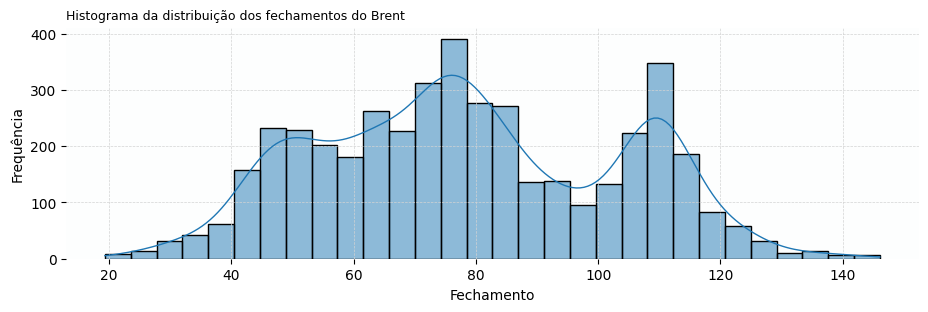

In [58]:
# @title
# Histograma do fechamento do Brent
plt.figure(figsize=(11, 3))
sns.histplot(df["fechamento"].dropna(), bins=30, kde=True)
plt.title("Histograma da distribui√ß√£o dos fechamentos do Brent", loc='left', fontsize=9)
plt.xlabel("Fechamento")
plt.ylabel("Frequ√™ncia")
plt.grid(True)
plt.show()


**Gr√°fico 2:** Histograma da distribui√ß√£o de frequ√™ncia dos fechamentos di√°rios do Brent (agosto de 2009 a fevereiro de 2025)

#### 1.2.2 Fechamentos Di√°rios: An√°lise Bivariada

A matriz de correla√ß√£o apresentada fornece um panorama geral das rela√ß√µes lineares entre as diferentes vari√°veis do Brent. Atrav√©s dela, √© poss√≠vel observar tr√™s pontos importantes:



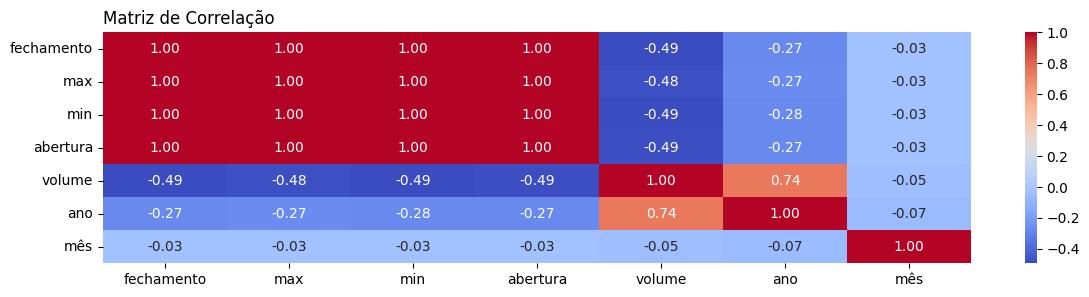

In [59]:
# @title
# Matriz de correla√ß√£o com Heatmap
plt.figure(figsize=(14, 3))
correlacao_matriz = df.corr(numeric_only=True)
sns.heatmap(correlacao_matriz, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correla√ß√£o", loc='left')
plt.show()



1. **Fechamento e Ano:** H√° uma correla√ß√£o negativa fraca (-0.27) entre o pre√ßo de fechamento e o ano, indicando que, ao longo do tempo, os pre√ßos tendem a cair ligeiramente, embora sem grande signific√¢ncia estat√≠stica. Isso √© evidenciado pelo Gr√°fico 2, que mostra uma leve tend√™ncia de queda nos fechamentos anuais do Brent nos √∫ltimos 18 anos. Ap√≥s o pico entre 2012 e 2013, houve uma forte queda entre 2014 e 2016, seguida por uma recupera√ß√£o gradual a partir de 2017. Nos anos mais recentes (2022-2025), os pre√ßos parecem ter se estabilizado em um patamar m√©dio, sugerindo que a OPEP tem atuado para controlar a volatilidade e evitar quedas mais acentuadas.






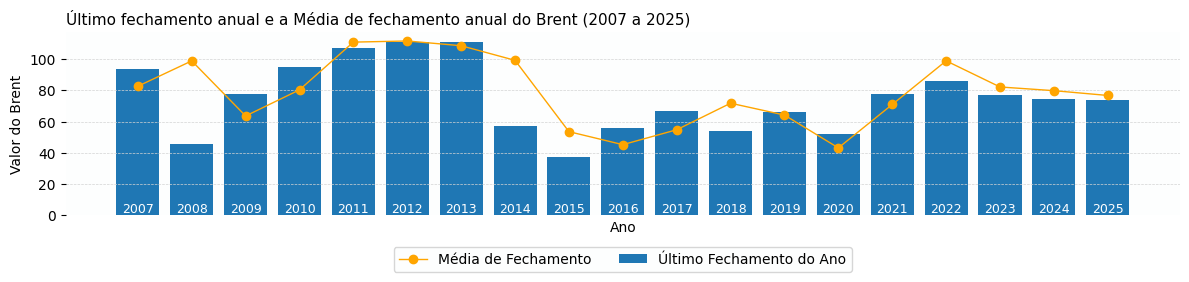

In [60]:
# @title
# Filtrando a √∫ltimo valor de fechamento para cada ano
ultima_pontuacao = df.groupby('ano')['fechamento'].last().reset_index()

# Calculando a m√©dia de fechamento para cada ano
media_fechamento = df.groupby('ano')['fechamento'].mean().reset_index()

# Criando o gr√°fico de barras
plt.figure(figsize=(12, 3))
bars = plt.bar(ultima_pontuacao['ano'], ultima_pontuacao['fechamento'], label='√öltimo Fechamento do Ano')

# Adicionando a linha da m√©dia de fechamento
plt.plot(media_fechamento['ano'], media_fechamento['fechamento'], color='orange', marker='o', label='M√©dia de Fechamento')

# Adicionando r√≥tulos e t√≠tulo
plt.xlabel('Ano')
plt.ylabel('Valor do Brent')
plt.title('√öltimo fechamento anual e a M√©dia de fechamento anual do Brent (2007 a 2025)', loc='Left', fontsize=11)
plt.grid()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
# Ajustar o layout para acomodar a legenda na parte inferior
plt.subplots_adjust(bottom=0.2)  # Ajuste este valor conforme necess√°rio


# Removendo os r√≥tulos do eixo x
plt.xticks([])

# Adicionando os anos abaixo das barras
for bar in bars:
    yval = bar.get_height()  # Altura da barra
    plt.text(bar.get_x() + bar.get_width() / 2, -0.5,
             str(int(bar.get_x() + 1)),  # O ano est√° na posi√ß√£o x + 1 da barra
             ha='center', va='bottom', color='white', fontsize=9)  # Alinhamento horizontal e vertical

# Exibindo o gr√°fico
plt.tight_layout()
plt.show()


**Gr√°fico 3:** Evolu√ß√£o do Brent ao Longo dos Anos: Compara√ß√£o entre a M√©dia Anual de Fechamento e o Valor do √öltimo Fechamento de Cada Ano (2007-2025)


2. **Volume e Ano:** H√° uma correla√ß√£o positiva (0.74) entre volume e ano, indicando que o volume de negocia√ß√µes aumentou ao longo do tempo, conforme demonstrado no Gr√°fico 4.

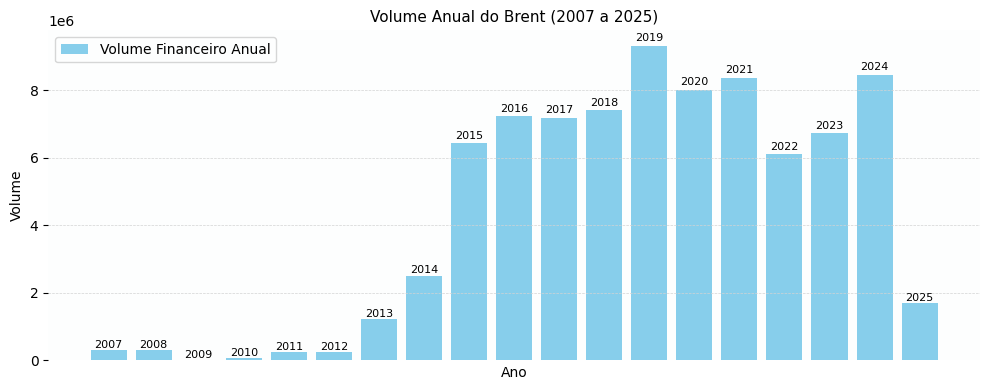

In [61]:
# @title
# Filtrando o volume financeiro total para cada ano
volume_anual = df.groupby('ano')['volume'].sum().reset_index()

# Criando o gr√°fico de barras
plt.figure(figsize=(10, 4))
bars = plt.bar(volume_anual['ano'], volume_anual['volume'], color='skyblue', label='Volume Financeiro Anual')

# Adicionando r√≥tulos e t√≠tulo
plt.xlabel('Ano')
plt.ylabel('Volume')
plt.title('Volume Anual do Brent (2007 a 2025)', loc='center', fontsize=11)
plt.legend()
plt.grid(axis='y')

# Removendo os r√≥tulos do eixo x
plt.xticks([])

# Adicionando os anos abaixo das barras
for bar in bars:
    yval = bar.get_height()  # Altura da barra
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01 * yval,
             str(int(bar.get_x() + 1)),  # O ano est√° na posi√ß√£o x + 1 da barra
             ha='center', va='bottom', color='black', fontsize=8)  # Alinhamento horizontal e vertical

# Exibindo o gr√°fico
plt.tight_layout()
plt.show()


**Gr√°fico 4:** Volume de a√ß√µes negociadas anualmente no Brent (07/2007 - 02/2025)



3. **M√™s com demais vari√°veis**: O m√™s do ano tem uma correla√ß√£o muito fraca com todas as outras vari√°veis, indicando que a sazonalidade mensal n√£o teve um impacto significativo no pre√ßo do Brent nos √∫ltimos 18 anos. Os gr√°ficos 5 e 6 corroboram o fato.







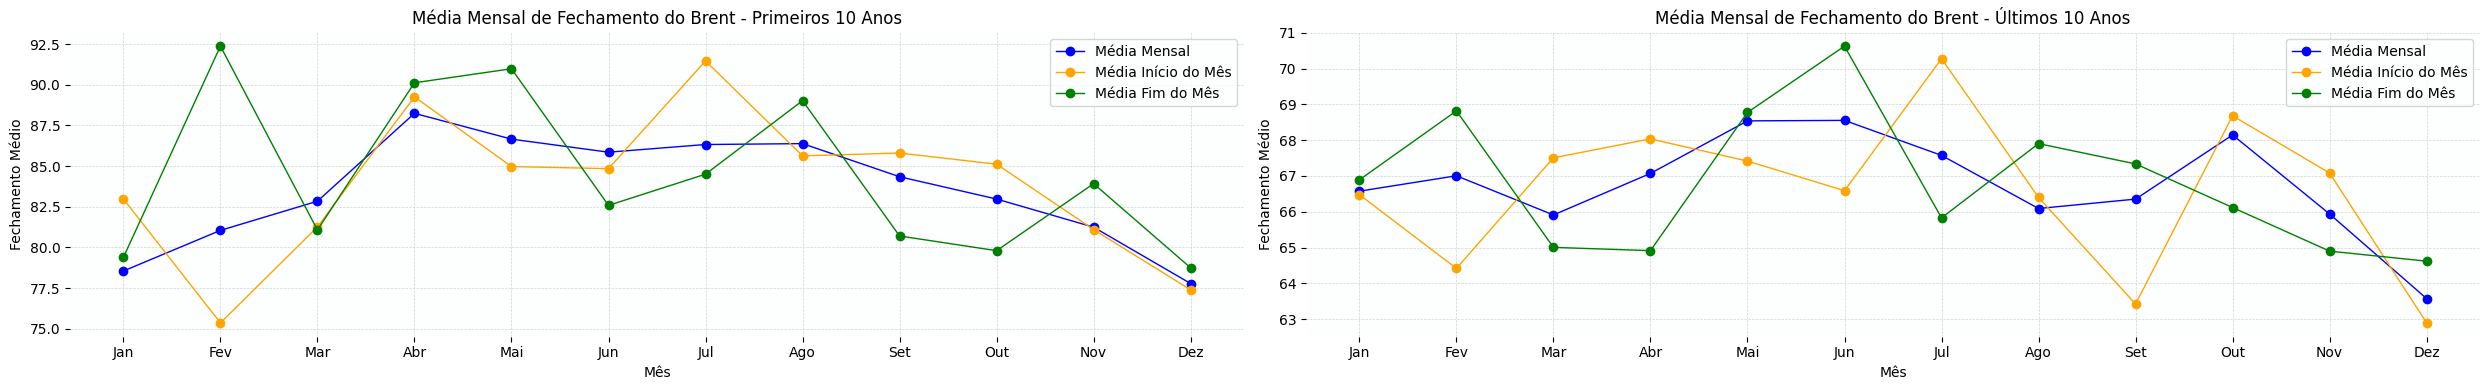

In [62]:
# @title

# Garantir que o √≠ndice do DataFrame seja datetime
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Filtrar para manter apenas a coluna 'fechamento'
df_filtered = df[['fechamento']].copy()  # Mant√©m a estrutura sem modificar a data

# Separar os dados nos primeiros 10 anos e nos √∫ltimos 10 anos
start_date = df_filtered.index.min()
end_date = df_filtered.index.max()

# Primeiros 10 anos
first_10_years = df_filtered[start_date:start_date.replace(year=start_date.year + 10)]
# √öltimos 10 anos
last_10_years = df_filtered[end_date.replace(year=end_date.year - 10):end_date]

# Fun√ß√£o para calcular m√©dias mensais
def calculate_monthly_averages(data):
    data = data.copy()  # Cria uma c√≥pia para evitar SettingWithCopyWarning
    data['month'] = data.index.month  # Extraindo o m√™s do √≠ndice
    start_of_month = data[data.index.day <= 5].groupby('month')['fechamento'].mean()
    end_of_month = data[data.index.day >= data.index.day.max() - 4].groupby('month')['fechamento'].mean()
    monthly_average = data.groupby('month')['fechamento'].mean()
    return monthly_average, start_of_month, end_of_month

# Calcular m√©dias para os primeiros 10 anos
monthly_average_1, start_of_month_1, end_of_month_1 = calculate_monthly_averages(first_10_years)

# Calcular m√©dias para os √∫ltimos 10 anos
monthly_average_2, start_of_month_2, end_of_month_2 = calculate_monthly_averages(last_10_years)

# Criar subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 4))

# Gr√°fico para os primeiros 10 anos
axs[0].plot(monthly_average_1.index, monthly_average_1.values, marker='o', label='M√©dia Mensal', color='blue')
axs[0].plot(start_of_month_1.index, start_of_month_1.values, marker='o', label='M√©dia In√≠cio do M√™s', color='orange')
axs[0].plot(end_of_month_1.index, end_of_month_1.values, marker='o', label='M√©dia Fim do M√™s', color='green')
axs[0].set_title('M√©dia Mensal de Fechamento do Brent - Primeiros 10 Anos')
axs[0].set_xlabel('M√™s')
axs[0].set_ylabel('Fechamento M√©dio')
axs[0].set_xticks(monthly_average_1.index)
axs[0].set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
axs[0].legend()
axs[0].grid(True)

# Gr√°fico para os √∫ltimos 10 anos
axs[1].plot(monthly_average_2.index, monthly_average_2.values, marker='o', label='M√©dia Mensal', color='blue')
axs[1].plot(start_of_month_2.index, start_of_month_2.values, marker='o', label='M√©dia In√≠cio do M√™s', color='orange')
axs[1].plot(end_of_month_2.index, end_of_month_2.values, marker='o', label='M√©dia Fim do M√™s', color='green')
axs[1].set_title('M√©dia Mensal de Fechamento do Brent - √öltimos 10 Anos')
axs[1].set_xlabel('M√™s')
axs[1].set_ylabel('Fechamento M√©dio')
axs[1].set_xticks(monthly_average_2.index)
axs[1].set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
axs[1].legend()
axs[1].grid(True)

# Ajustar o espa√ßo entre os subplots
plt.subplots_adjust(hspace=2)
plt.tight_layout()
plt.show()


**Gr√°fico 5:** Compara√ß√£o da Performance Mensal do Brent em Diferentes D√©cadas

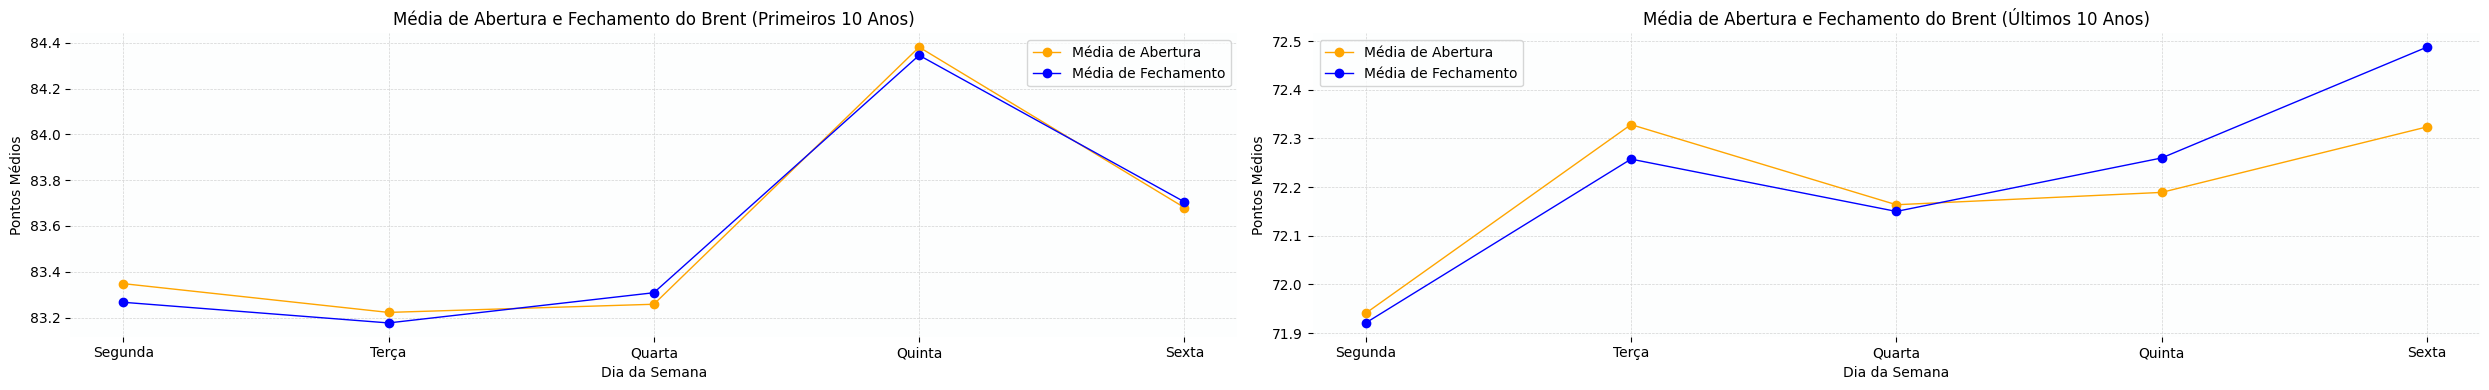

In [63]:
# @title

# Filtrar para manter apenas as colunas 'abertura' e 'fechamento'
df_filtered = df[['abertura', 'fechamento']].copy()

# Garantir que o √≠ndice √© do tipo datetime (se j√° n√£o for)
if not isinstance(df_filtered.index, pd.DatetimeIndex):
    df_filtered.index = pd.to_datetime(df_filtered.index)

# Criar subconjuntos para os 10 primeiros anos e os √∫ltimos 10 anos
first_10_years = df_filtered[df_filtered.index < df_filtered.index.min() + pd.DateOffset(years=10)].copy()
last_10_years = df_filtered[df_filtered.index >= df_filtered.index.min() + pd.DateOffset(years=10)].copy()

# Fun√ß√£o para calcular a m√©dia de abertura e fechamento por dia da semana
def calculate_weekly_averages(df):
    df = df.copy()  # Garantir que estamos trabalhando com uma c√≥pia
    df['day_of_week'] = df.index.dayofweek  # Extraindo o dia da semana do √≠ndice
    weekly_open_avg = df.groupby('day_of_week')['abertura'].mean().reset_index()
    weekly_close_avg = df.groupby('day_of_week')['fechamento'].mean().reset_index()

    # Renomear os dias da semana
    days = {0: 'Segunda', 1: 'Ter√ßa', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta'}
    weekly_open_avg['day_of_week'] = weekly_open_avg['day_of_week'].replace(days)
    weekly_close_avg['day_of_week'] = weekly_close_avg['day_of_week'].replace(days)

    return weekly_open_avg, weekly_close_avg

# Calcular m√©dias para os 10 primeiros anos
weekly_open_avg_first, weekly_close_avg_first = calculate_weekly_averages(first_10_years)

# Calcular m√©dias para os √∫ltimos 10 anos
weekly_open_avg_last, weekly_close_avg_last = calculate_weekly_averages(last_10_years)

# Criar os gr√°ficos
fig, axs = plt.subplots(1, 2, figsize=(25, 4))

# Gr√°fico para os 10 primeiros anos
axs[0].plot(weekly_open_avg_first['day_of_week'], weekly_open_avg_first['abertura'], marker='o', label='M√©dia de Abertura', color='orange')
axs[0].plot(weekly_close_avg_first['day_of_week'], weekly_close_avg_first['fechamento'], marker='o', label='M√©dia de Fechamento', color='blue')
axs[0].set_title('M√©dia de Abertura e Fechamento do Brent (Primeiros 10 Anos)')
axs[0].set_xlabel('Dia da Semana')
axs[0].set_ylabel('Pontos M√©dios')
axs[0].legend()
axs[0].grid(True)

# Gr√°fico para os √∫ltimos 10 anos
axs[1].plot(weekly_open_avg_last['day_of_week'], weekly_open_avg_last['abertura'], marker='o', label='M√©dia de Abertura', color='orange')
axs[1].plot(weekly_close_avg_last['day_of_week'], weekly_close_avg_last['fechamento'], marker='o', label='M√©dia de Fechamento', color='blue')
axs[1].set_title('M√©dia de Abertura e Fechamento do Brent (√öltimos 10 Anos)')
axs[1].set_xlabel('Dia da Semana')
axs[1].set_ylabel('Pontos M√©dios')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  # Ajustar o layout para evitar sobreposi√ß√£o
plt.show()


**Gr√°fico 6:** Compara√ß√£o da Performance Semanal do Brent em Diferentes D√©cadas

### 1.3 An√°lise da S√©rie Temporal

Ap√≥s a an√°lise dos dados, foi realizada a decomposi√ß√£o da s√©rie temporal do Brent e aplicado o teste de raiz unit√°ria de Dickey-Fuller para verificar a estacionariedade. Esta etapa √© crucial, pois a maioria dos modelos de aprendizado de m√°quina assume que os dados s√£o estacion√°rios. A n√£o estacionariedade pode levar a modelos imprecisos e previs√µes err√¥neas. Caso a s√©rie n√£o seja estacion√°ria, transforma√ß√µes como a diferencia√ß√£o podem ser aplicadas para torn√°-la estacion√°ria.


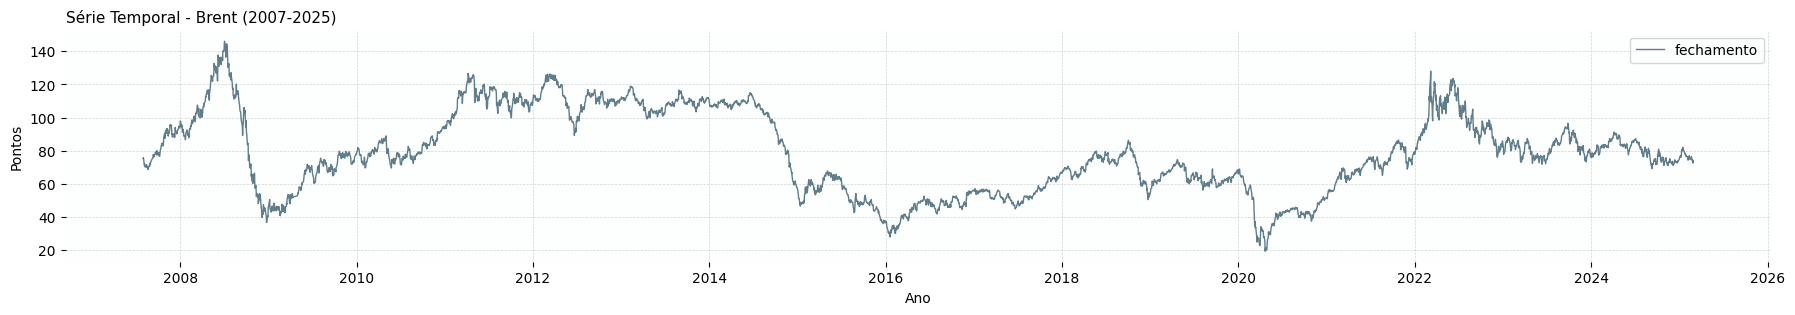

In [64]:
# @title
# Configura o tamanho do gr√°fico (largura, altura)
figsize = (22, 3)  # Altere para o tamanho desejado
plt.figure(figsize=figsize)

# Gr√°fico principal (IBOVESPA)
plt.plot(df.index, df['fechamento'], label='fechamento', color='#607d8b')

# Definir intervalo de 2 anos no eixo X
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Define o intervalo de 2 anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato do r√≥tulo do eixo X

# Configura√ß√µes adicionais do gr√°fico
plt.title('S√©rie Temporal - Brent (2007-2025)', loc="Left", fontsize=11)
plt.ylabel('Pontos')
plt.xlabel('Ano')
plt.grid(True)
plt.legend()

# Mostrar o gr√°fico
plt.show()


**Gr√°fico 7:** S√©rie Temporal dos fechamentos di√°rios do Brent dos √∫ltimos
18 anos.

#### 1.3.1 Decomposi√ß√£o da S√©rie Temporal

S√©ries temporais apresentam caracter√≠sticas como tend√™ncia, sazonalidade, res√≠duo e autocorrela√ß√£o. A decomposi√ß√£o da s√©rie do Brent permite isolar esses componentes, proporcionando uma an√°lise mais precisa e detalhada desses componentes.





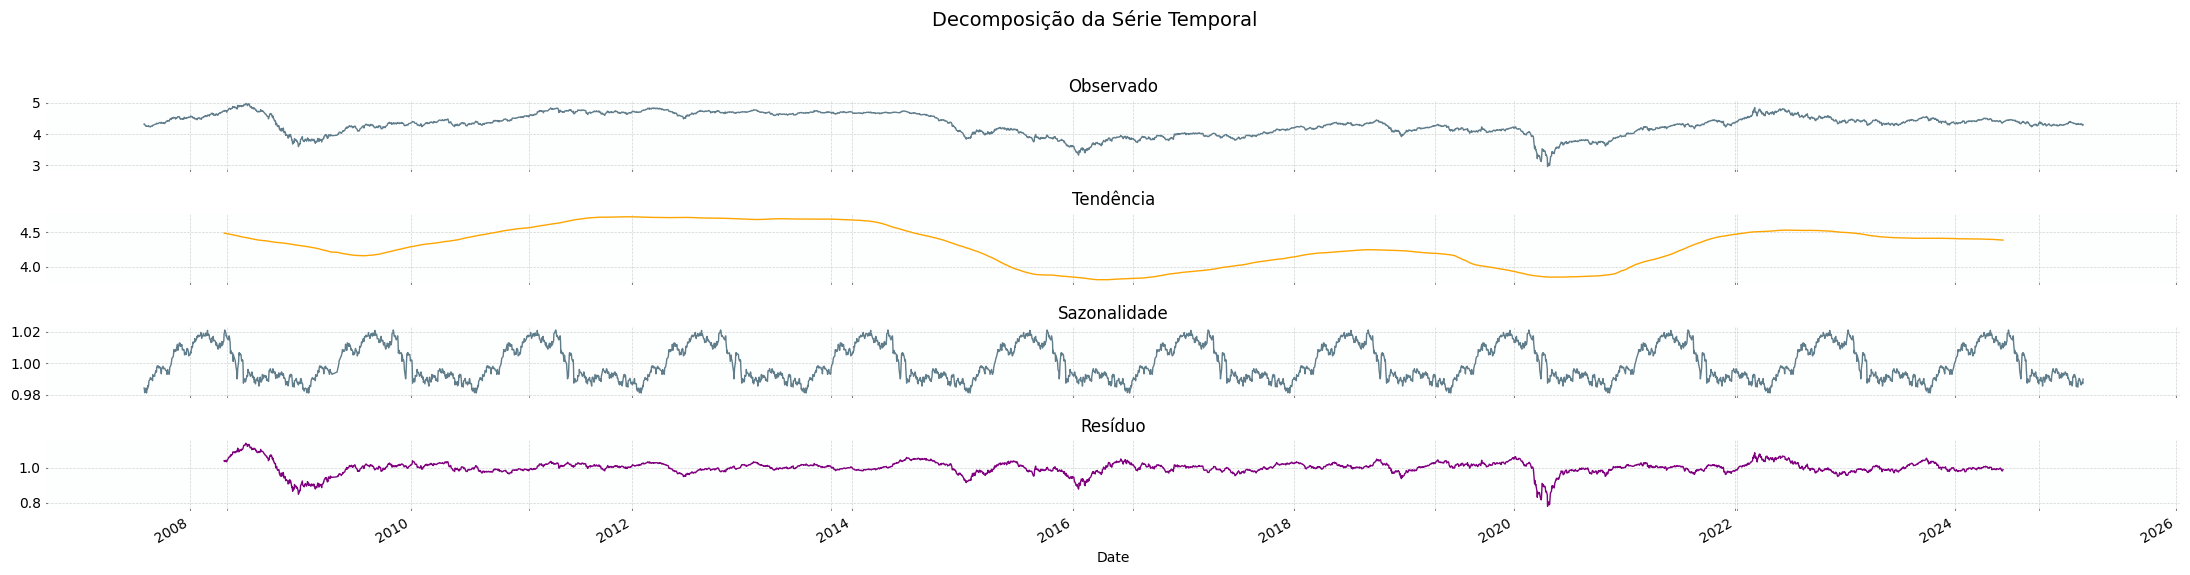

In [65]:
# @title
# Transforma√ß√£o logar√≠tmica para estabilizar a vari√¢ncia, se os valores forem todos positivos
df["fechamento_log"] = np.log(df["fechamento"])

# Decomposi√ß√£o multiplicativa pode ser tentada se os componentes forem proporcionais ao n√≠vel da s√©rie
result = seasonal_decompose(df["fechamento_log"], model="multiplicative", period=365)

# Plotando o resultado
fig, axes = plt.subplots(4, 1, figsize=(22, 6), sharex=True)
result.observed.plot(ax=axes[0], title='Observado', color='#607d8b')
result.trend.plot(ax=axes[1], title='Tend√™ncia', color='orange')
result.seasonal.plot(ax=axes[2], title='Sazonalidade', color='#607d8b')
result.resid.plot(ax=axes[3], title='Res√≠duo', color='purple')

# Configura√ß√µes de grid e linhas externas
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='both', length=1)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_color('black')  # Linha esquerda em preto
    ax.spines['bottom'].set_color('black')  # Linha inferior em preto

# T√≠tulo geral do gr√°fico
fig.suptitle('Decomposi√ß√£o da S√©rie Temporal', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Exibindo o gr√°fico
plt.show()


**Gr√°fico 8:** Decomposi√ß√£o da S√©rie Temporal do fechamento do Brent em seus 4 componentes principais.

##### 1.3.1.1 Tend√™ncia

**O que √©:** Refere-se ao movimento de longo prazo nos dados. √â a parte da s√©rie que representa o crescimento ou decl√≠nio gradual ao longo do tempo.

**Resultado:** A s√©rie temporal do Brent n√£o exibe uma tend√™ncia linear consistente, indicando que os valores de fechamento n√£o seguem um padr√£o claro de crescimento ou decl√≠nio ao longo do tempo, apesar das varia√ß√µes di√°rias t√≠picas do mercado. Nesse contexto, a **an√°lise por m√©dias m√≥veis se mostra mais eficaz para identificar padr√µes e tend√™ncias na s√©rie temporal do Brent**.




*Saiba mais em detalhes ‚Üì*


A an√°lise de regress√£o linear (Gr√°fico 9) revela que a tend√™ncia dos fechamentos do Brent √© muito sutil, com um R¬≤ de 0,0756, indicando que apenas 7,56% da varia√ß√£o dos pre√ßos di√°rios √© explicada pelo tempo. Esse resultado evidencia a forte influ√™ncia de fatores externos e a alta volatilidade do mercado de petr√≥leo, tornando um modelo linear simples insuficiente para capturar suas oscila√ß√µes.









In [66]:
# @title
# Converte a coluna 'data' para n√∫mero de dias a partir da data m√≠nima
df['data_numerica'] = (df.index - df.index.min()).days

# Vari√°vel independente (agora num√©rica)
x = df[['data_numerica']].values.reshape(-1, 1)

# Vari√°vel dependente
y = df['fechamento'].values

# Cria e ajusta o modelo de regress√£o linear
model = LinearRegression()
model.fit(x, y)

# Faz as previs√µes com base nos dados de entrada
y_pred = model.predict(x)

# Calcula o coeficiente de determina√ß√£o (R¬≤)
r2 = r2_score(y, y_pred)

print(f"Coeficiente de Determina√ß√£o (R¬≤): {r2:.4f}")


Coeficiente de Determina√ß√£o (R¬≤): 0.0756


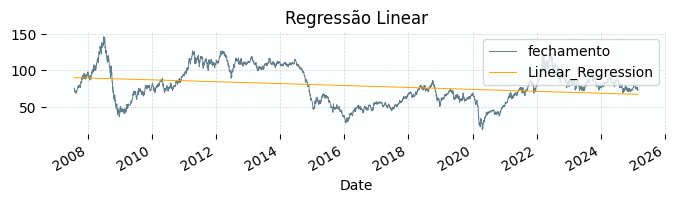

In [67]:
# @title
# Preparando os dados
X = np.arange(len(df)).reshape(-1, 1)
y = df["fechamento"].values

# Modelo de Regress√£o Linear
model = LinearRegression()
model.fit(X, y)
df["Linear_Regression"] = model.predict(X)

# Plotando os resultados
df[["fechamento", "Linear_Regression"]].plot(title="Regress√£o Linear", figsize=(8, 1.5), color=["#607d8b", "orange"], linewidth=0.7)
plt.grid(True)
plt.show()

**Gr√°fico 9:** Regress√£o Linear do fechamento di√°rio do Brent.


Para capturar melhor essas din√¢micas, foi empregada a an√°lise de m√©dia m√≥vel de 80 dias. Ao considerar a m√©dia m√≥vel, obteve-se um erro percentual absoluto m√©dio (MAPE) de apenas 9,79%, indicando um ajuste mais preciso aos dados e uma melhor capacidade de acompanhar as flutua√ß√µes de curto prazo do √≠ndice.

Vale destacar que a m√©dia m√≥vel de 80 dias foi escolhida com base na primeira an√°lise realizada com a janela de 200 dias, um indicador t√©cnico amplamente utilizado no mercado financeiro.



> A m√©dia m√≥vel √© um indicador t√©cnico amplamente utilizado na an√°lise de mercado para suavizar os dados de pre√ßos de um ativo e identificar tend√™ncias. Ela √© calculada tomando a m√©dia dos pre√ßos de um determinado per√≠odo, como por exemplo, os √∫ltimos 80 dias.




In [68]:
# @title
# Calcular a m√©dia m√≥vel de 100 dias
df['media_movel_80'] = df['fechamento'].rolling(window=80).mean()

# Ignorar os valores onde a m√©dia m√≥vel n√£o √© definida (primeiros 99 valores)
valid_mask = df['media_movel_80'].notna()

# Calcular o Erro Quadr√°tico M√©dio (EQM) e o Erro Absoluto M√©dio (EAM)
eqm = np.mean((df.loc[valid_mask, 'fechamento'] - df.loc[valid_mask, 'media_movel_80']) ** 2)
eam = np.mean(np.abs(df.loc[valid_mask, 'fechamento'] - df.loc[valid_mask, 'media_movel_80']))

# Calcular o MAPE
mape = np.mean(np.abs((df.loc[valid_mask, 'fechamento'] - df.loc[valid_mask, 'media_movel_80']) / df.loc[valid_mask, 'fechamento'])) * 100

# Imprimir os resultados
print(f'Erro Quadr√°tico M√©dio (EQM) com janela de 80 dias: {eqm:.2f}')
print(f'Erro Absoluto M√©dio (EAM) com janela de 80 dias: {eam:.2f}')
print(f'Erro Percentual Absoluto M√©dio (MAPE) com janela de 80 dias: {mape:.2f}%')


Erro Quadr√°tico M√©dio (EQM) com janela de 80 dias: 87.18
Erro Absoluto M√©dio (EAM) com janela de 80 dias: 6.58
Erro Percentual Absoluto M√©dio (MAPE) com janela de 80 dias: 9.79%


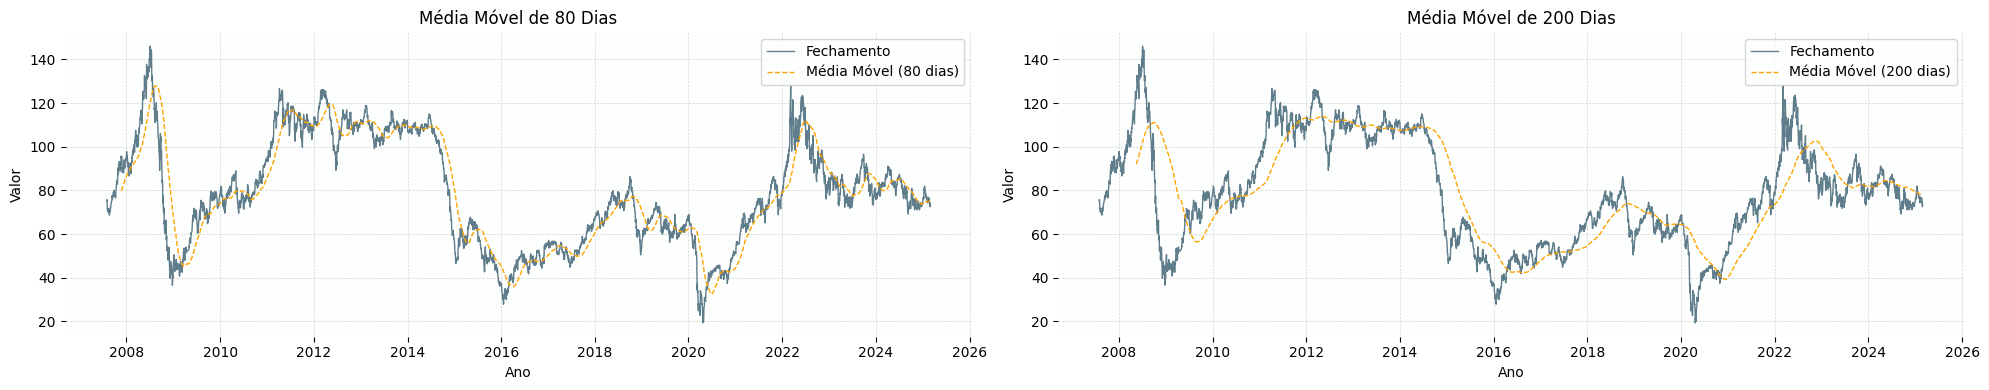

In [69]:
# @title

def plot_moving_averages(data, column, title='', ylabel='', xlabel=''):
    # Criar uma figura com dois subgr√°ficos
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))

    # Plotar a m√©dia m√≥vel de 80 dias
    ax[0].plot(data.index, data[column], label='Fechamento', color='#607d8b')
    rolling_mean_80 = data[column].rolling(window=80).mean()
    ax[0].plot(data.index, rolling_mean_80, label='M√©dia M√≥vel (80 dias)', color='orange', linestyle='--')

    # Definir intervalo de 2 anos no eixo X para o primeiro gr√°fico
    ax[0].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[0].set_title('M√©dia M√≥vel de 80 Dias')
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    ax[0].grid(True)
    ax[0].legend()

    # Plotar a m√©dia m√≥vel de 200 dias
    ax[1].plot(data.index, data[column], label='Fechamento', color='#607d8b')
    rolling_mean_200 = data[column].rolling(window=200).mean()
    ax[1].plot(data.index, rolling_mean_200, label='M√©dia M√≥vel (200 dias)', color='orange', linestyle='--')

    # Definir intervalo de 2 anos no eixo X para o segundo gr√°fico
    ax[1].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[1].set_title('M√©dia M√≥vel de 200 Dias')
    ax[1].set_ylabel(ylabel)
    ax[1].set_xlabel(xlabel)
    ax[1].grid(True)
    ax[1].legend()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Usar a fun√ß√£o para plotar as m√©dias m√≥veis
plot_moving_averages(data=df, column='fechamento',
                     title='M√©dias M√≥veis do Brent',
                     ylabel='Valor', xlabel='Ano')


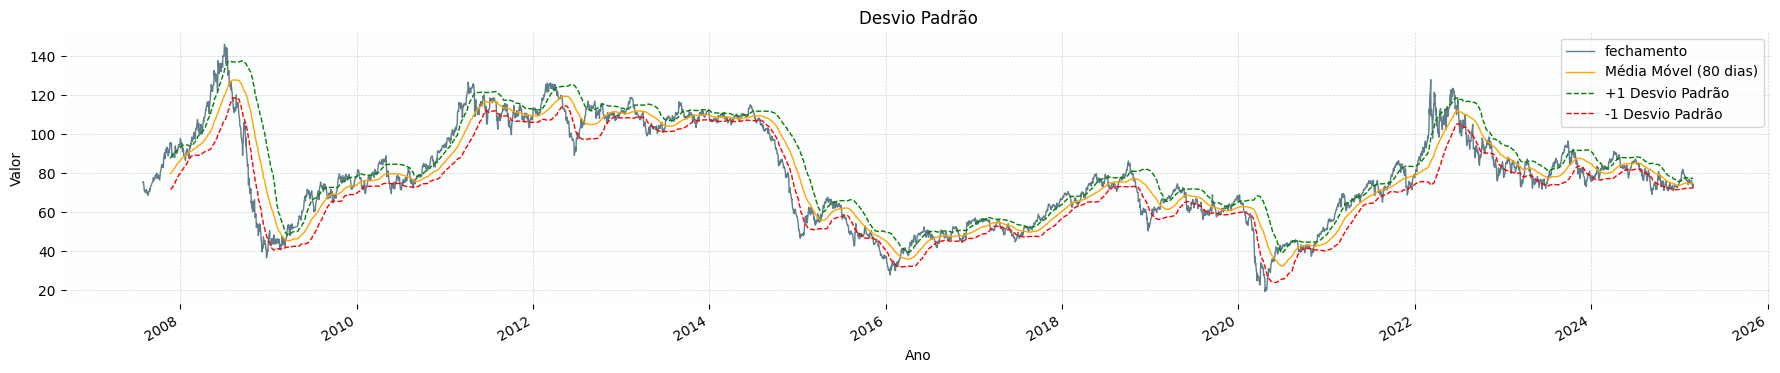

In [70]:
# @title
# Desvio padr√£o
def plot_series_with_events(data, column, events, bars_data=None, title='', ylabel='', xlabel=''):
    ## Gr√°fico Principal (Brent)
    plt.figure(figsize=(22, 4))
    ax = data[column].plot(label=column, color='#607d8b')  # Plot do fechamento

    # C√°lculo da m√©dia m√≥vel e desvio padr√£o
    rolling_mean = data[column].rolling(window=80).mean()
    std_dev = data[column].rolling(window=80).std()

    # Plot da m√©dia m√≥vel e suas bandas de desvio padr√£o
    rolling_mean.plot(ax=ax, label='M√©dia M√≥vel (80 dias)', color='orange')
    (rolling_mean + std_dev).plot(ax=ax, label='+1 Desvio Padr√£o', color='green', linestyle='--')
    (rolling_mean - std_dev).plot(ax=ax, label='-1 Desvio Padr√£o', color='red', linestyle='--')

    # Definir intervalo de 2 anos no eixo X
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Define o intervalo de 2 anos
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato do r√≥tulo do eixo X

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# Usar a fun√ß√£o para plotar a s√©rie do fechamento do Brent com eventos
plot_series_with_events(data=df, column='fechamento', events=eventos,
                            title='Desvio Padr√£o',
                            ylabel='Valor', xlabel='Ano')


**Gr√°fico 10:** An√°lise de Tend√™ncia de Longo Prazo do Brent: Compara√ß√£o entre M√©dias M√≥veis de 80 e 200 Dias.

##### 1.3.1.2 Sazonalidade


**O que √©:** O componente de sazonalidade mostra padr√µes repetitivos em intervalos regulares.

**Resultado:** A complexidade da sazonalidade do Brent reside na varia√ß√£o de seus ciclos, tanto em dura√ß√£o quanto em intensidade. Essa oscila√ß√£o refor√ßa a influ√™ncia de fatores macroecon√¥micos, geopol√≠ticos e de oferta/demanda, o que dificulta a decomposi√ß√£o sazonal.




*Saiba mais em detalhes ‚Üì*


A fun√ß√£o seasonal_decompose foi utilizada para entender a sazonalidade da s√©rie. Foram analisados 4 diferentes periodos na busca por uma sazonalidade:


* **180 dias (6 meses):** Apresenta picos regulares seguidos de quedas, sugerindo ciclos curtos de alta demanda seguidos por corre√ß√µes. Possivelmente ligados a estoques e sazonalidade industrial.

* **365 dias (1 ano)**: Come√ßa subindo no in√≠cio do ano e desacelera ao longo do per√≠odo. Reflete padr√µes anuais de consumo, como maior demanda no inverno e ajustes da OPEP.

* **540 dias (1,5 anos):** Mostra tend√™ncias menos sim√©tricas, com oscila√ß√µes mais suaves e ciclos de alta seguidos por quedas moderadas. Pode indicar realinhamentos de oferta e demanda globais.

* **730 dias (2 anos):** Mostra ciclos de alta seguidos por per√≠odos prolongados de estabiliza√ß√£o ou queda. Indica movimentos estruturais do mercado, como choques de oferta, crises econ√¥micas e mudan√ßas na geopol√≠tica do petr√≥leo.



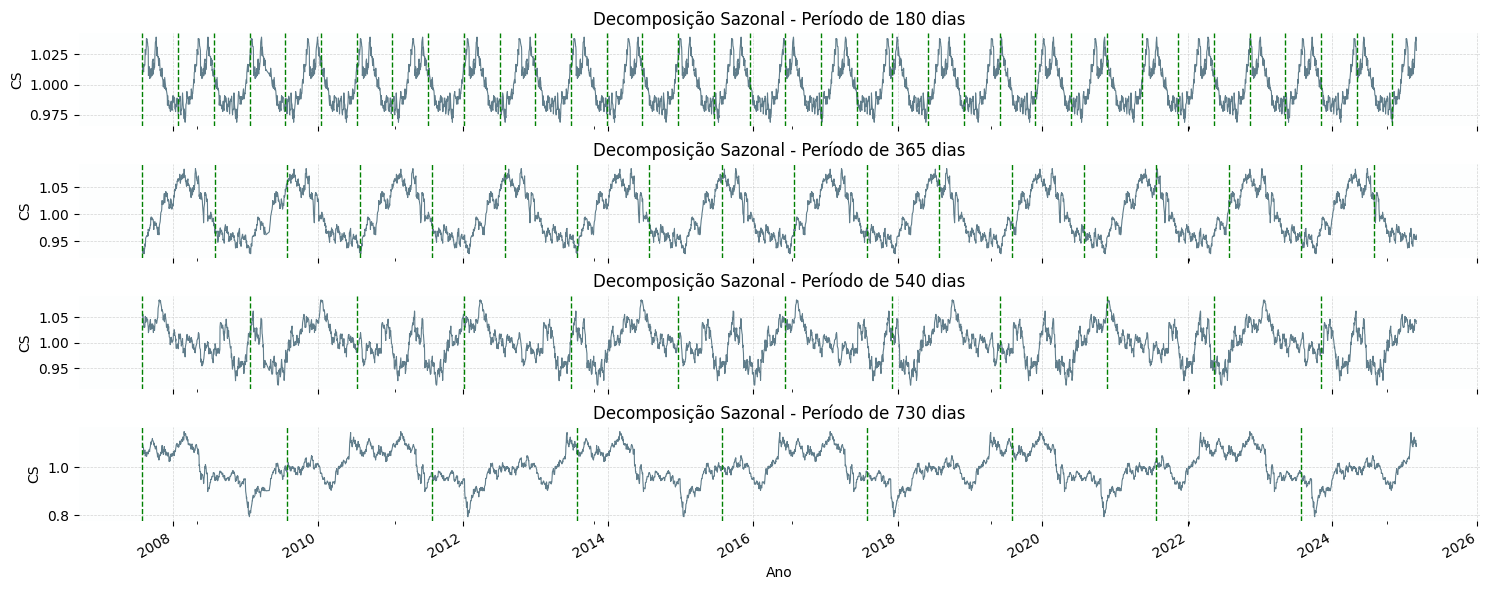

In [71]:
# @title

# Lista de per√≠odos a serem analisados
periods = [180, 365,540, 730]
titles = ["180 dias", "365 dias","540 dias", "730 dias"]

# Criar figura com tr√™s subgr√°ficos
fig, axes = plt.subplots(4, 1, figsize=(15, 6), sharex=True)

for i, period in enumerate(periods):
    # Decomposi√ß√£o sazonal
    result = seasonal_decompose(df["fechamento"], model="multiplicative", period=period)
    df_seasonal = result.seasonal.to_frame(name="seasonal")
    df_seasonal = df_seasonal[df_seasonal.index >= "2007-01-01"]  # Filtrar a partir de 2007

    # Plotar o gr√°fico
    ax = axes[i]
    df_seasonal.plot(ax=ax, color="#607d8b", linewidth=0.8, legend=False)

    # Adicionar linhas vermelhas a cada per√≠odo
    start_date = df_seasonal.index.min()
    end_date = df_seasonal.index.max()
    periodic_ticks = pd.date_range(start=start_date, end=end_date, freq=f'{period}D')
    for date in periodic_ticks:
        ax.axvline(date, color='green', linestyle='--', linewidth=1)

    ax.set_title(f"Decomposi√ß√£o Sazonal - Per√≠odo de {titles[i]}")
    ax.set_ylabel("CS")
    ax.grid(True)

plt.xlabel("Ano")
plt.tight_layout()
plt.show()





**Gr√°fico 11:** O gr√°fico mostra o Componente Sazonal (CS) de uma s√©rie temporal do fechamento do Brent, usando uma decomposi√ß√£o sazonal multiplicativa com um per√≠odo de 365, 540 e 730 dias.

##### 1.3.1.3 Res√≠duo

**O que √©:** O res√≠duo representa as varia√ß√µes n√£o explicadas pela tend√™ncia e pela sazonalidade, ou seja, os movimentos aleat√≥rios e imprevis√≠veis do mercado.

**Resultado:** A an√°lise dos res√≠duos corrobora a observa√ß√£o inicial de que os movimentos aleat√≥rios do Brent est√£o frequentemente relacionados a  fatores macroecon√¥micos, geopol√≠ticos e oferta/demanda.






*Saiba mais em detalhes ‚Üì*

A an√°lise dos res√≠duos do Brent revela picos e vales ligados a per√≠odos de alta volatilidade, geralmente impulsionados por eventos que afetam abruptamente o mercado.

A crise financeira de 2008, por exemplo, desencadeou quedas acentuadas nos pre√ßos. J√° os cortes de produ√ß√£o acordados pela OPEP no final de 2016 impulsionaram os pre√ßos entre 2017 e 2018. A pandemia de COVID-19 em 2020 causou uma queda brusca, enquanto a guerra na Ucr√¢nia em 2022 exerceu press√£o de alta sobre os pre√ßos.



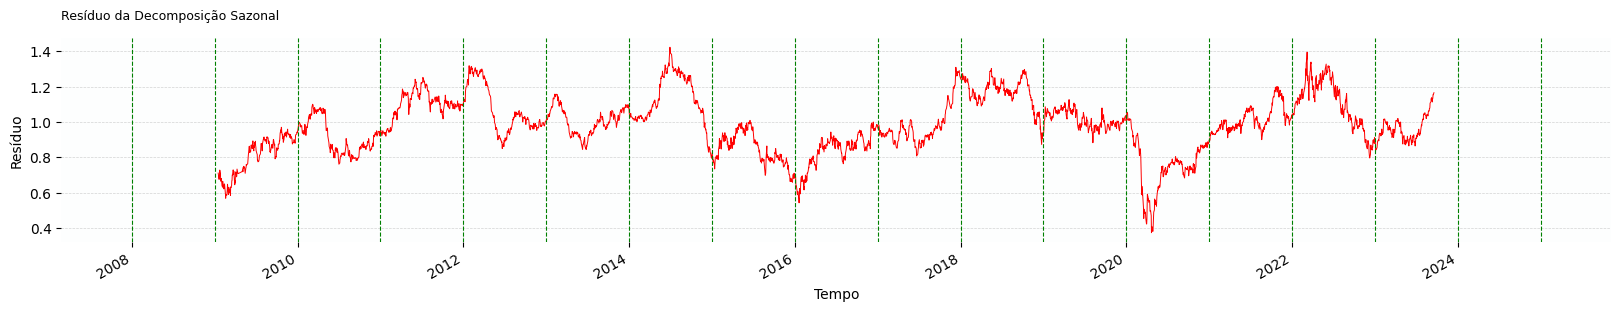

In [72]:
# @title
# Filtrar os res√≠duos a partir de 2007
resid_2007 = result.resid[result.resid.index >= "2007-01-01"]

# Criar a figura
fig, ax = plt.subplots(figsize=(20, 3))
resid_2007.plot(ax=ax, color="red", linewidth=0.7)
ax.set_title("Res√≠duo da Decomposi√ß√£o Sazonal", fontsize=9, loc='left', y=1.05)
ax.set_ylabel("Res√≠duo")
ax.set_xlabel("Tempo")

# N√∫mero total de pontos de dados (dias) no res√≠duo filtrado
total_dias = len(resid_2007)

# Criar os anos para marca√ß√£o
anos = pd.date_range(start=resid_2007.index.min(), end=resid_2007.index.max(), freq='YS')

# Adicionar linhas verticais para identificar os anos
for ano in anos:
    ax.axvline(x=ano, color='green', linestyle='--', linewidth=0.8)

plt.grid(True)
plt.show()



**Gr√°fico 12:** Res√≠duo da S√©rie Temporal do Brent (2007 - 2025)

#### 1.3.2 Decomposi√ß√£o Autoregressiva

Ap√≥s analisar a tend√™ncia, sazonalidade e res√≠duos da s√©rie temporal do Brent, realizou-se o estudo de autocorrela√ß√£o para embasar a modelagem de machine learning.

**Resultado:** Ao final do estudo foi observado que a s√©rie temporal do Brent revelou um ACF alto/persistente (227 lag)e PACF com corte r√°pido (2), o que √© caracter√≠stico de s√©ries com forte componente autorregressiva, possivelmente integradas.  √â comum em s√©ries de pre√ßos financeiros e sugere que, embora a hist√≥ria distante importa para o comportamento geral da s√©rie, para fins de previs√£o imediata, √© necess√°rio considerar os dois dias anteriores.

Essa combina√ß√£o exige um modelo de previs√£o que capture tanto a depend√™ncia de longo prazo quanto os efeitos de curto prazo. Modelos ARIMA, por sua flexibilidade, s√£o os mais adequados para ajustar essa s√©rie, permitindo capturar essas duas din√¢micas.








*Saiba mais em detalhes ‚Üì*

##### 1.3.2.1 Autocorrela√ß√£o



**O que √©:** A autocorrela√ß√£o √© um fen√¥meno estat√≠stico que mede a depend√™ncia entre os valores passados e presentes de uma s√©rie temporal. Uma alta autocorrela√ß√£o significa que os valores anteriores influenciam significativamente os valores futuros. No cen√°rio do Brent indica que os valores de um dia podem influenciar os dias seguintes, criando padr√µes. No entanto, √© importante lembrar que o ACF mostra apenas padr√µes passados e n√£o garante o comportamento futuro do mercado.

**Resultado:** A s√©rie do Brent apresenta uma autocorrela√ß√£o que diminui √† medida que os lags aumentam, sugerindo que a influ√™ncia dos valores passados na previs√£o dos valores futuros diminui com o tempo.







*Saiba mais em detalhes ‚Üì*

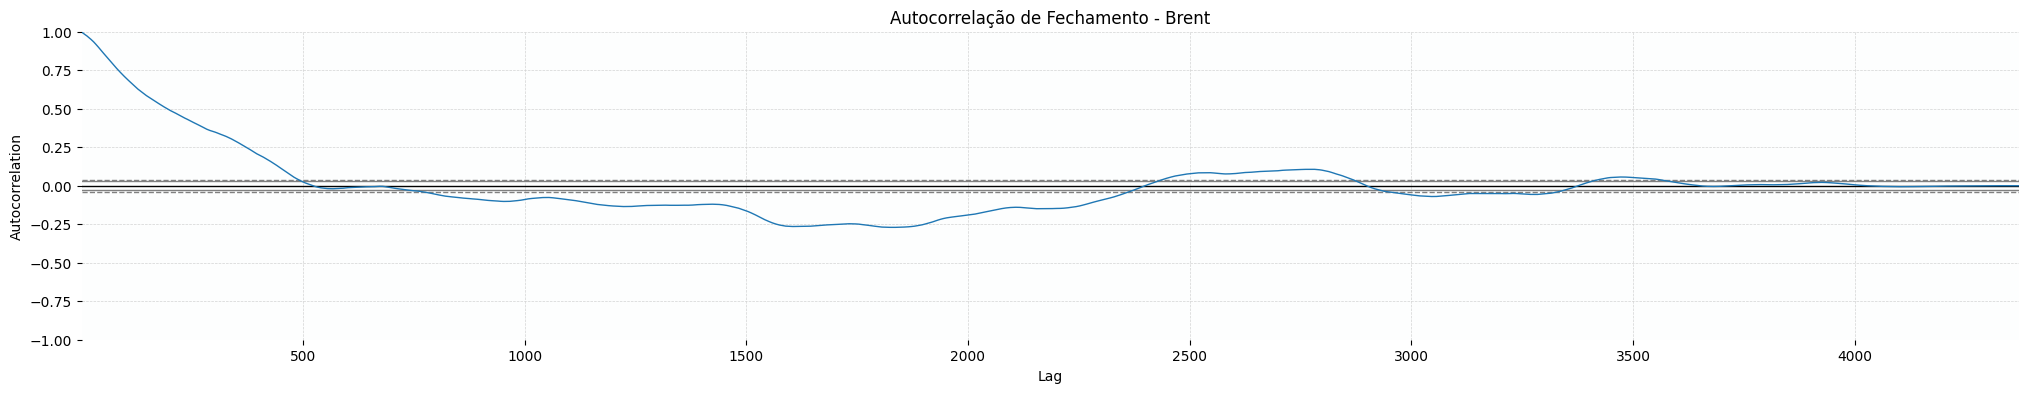

In [73]:
# @title
# Configurar o tamanho do gr√°fico
plt.figure(figsize=(25, 4))  # Altere os valores para ajustar a largura e a altura do gr√°fico

# Plotar a autocorrela√ß√£o
autocorrelation_plot(df['fechamento'])
plt.title('Autocorrela√ß√£o de Fechamento - Brent')
plt.show()


**Gr√°fico 13:** Autocorrela√ß√£o da S√©rie Temporal do Brent (2007 - 2025)

O gr√°fico de autocorrela√ß√£o do Brent (Gr√°fico 13) mostra uma forte correla√ß√£o nos primeiros 500 dias, indicando que os pre√ßos mant√™m uma "mem√≥ria" de cerca de dois anos de negocia√ß√£o. Ap√≥s esse per√≠odo, a correla√ß√£o diminui gradualmente e oscila pr√≥ximo de zero, sugerindo que o impacto dos eventos passados enfraquece com o tempo. Entre os lags 1500-2000 (cerca de 6-8 anos), observa-se uma autocorrela√ß√£o negativa, o que pode refletir ciclos de longo prazo ou revers√µes de tend√™ncia no mercado de petr√≥leo. Com o tempo, a autocorrela√ß√£o tende a zero, indicando que eventos muito antigos deixam de influenciar os pre√ßos atuais.


 Esse padr√£o sugere que modelos preditivos podem se beneficiar de dados hist√≥ricos de at√© 500 dias, enquanto per√≠odos mais longos oferecem retornos decrescentes.

##### 1.3.2.2 ACF

**O que √©:** O ACF, ou Fun√ß√£o de Autocorrela√ß√£o (Autocorrelation Function), √© uma ferramenta usada para medir qu√£o forte √© a autocorrela√ß√£o nos dados ao longo de diferentes intervalos de tempo. Permitindo, assim, a identifica√ß√£o de padr√µes repetitivos nos dados, como tend√™ncias de alta ou baixa.

**Resultado:** A s√©rie apresenta ACF alto e de decaimento lento, indicando uma forte persist√™ncia na s√©rie temporal, onde valores passados continuam influenciando os valores atuais por longos per√≠odos (at√© 227 lags). Isso sugere mem√≥ria longa e poss√≠vel n√£o-estacionariedade na s√©rie.

Por fim, atrav√©s desta an√°lise fica claro que modelos de aprendizado de curto prazo podem n√£o ser adequados. √â preciso utilizar modelos que capturam a sazonalidade de longo prazo, como SARIMA. Assim como realizar a transforma√ß√£o da s√©rie (diferencia√ß√£o) para obter um resultado melhor com o modelo de aprendizado.






*Saiba mais em detalhes ‚Üì*

Os coeficientes ACF interceptam o limiar no lag 227


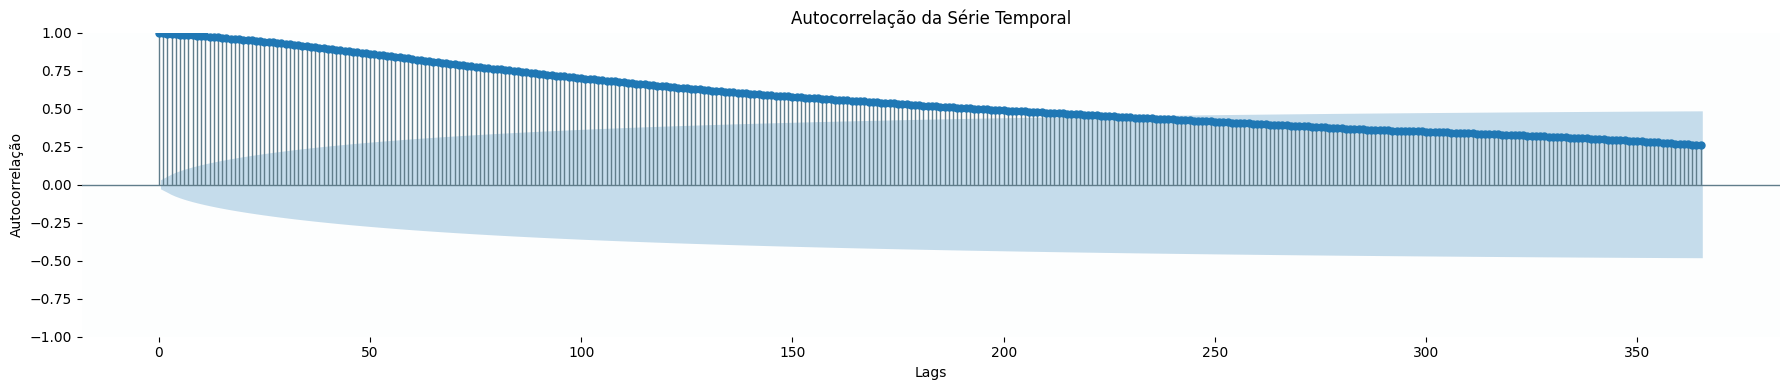

In [74]:
# @title
# acf
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf

def plot_acf(df, lags=365, title="Autocorrela√ß√£o da S√©rie Temporal"):

    fig, ax = plt.subplots(figsize=(18, 4))
    # Get the ACF values and confidence intervals
    _plot_acf(df, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrela√ß√£o")
    fig.set_tight_layout(True)

    #AONDE ESTA MEU PONTO DE CORTE (ACF)
    acf_x = sm.tsa.acf(df, alpha=0.05, nlags=500)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes ACF interceptam o limiar no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes ACF n√£o interceptam o limiar")

plot_acf(df['fechamento'])

**Gr√°fico 14:** Autocorrela√ß√£o da S√©rie Temporal do Brent com lag 227 (2007 - 2025)

Analisando o gr√°fico de autocorrela√ß√£o do Brent, nota-se que os coeficientes ACF interceptam o limiar apenas no lag 227, indicando uma mem√≥ria longa na s√©rie temporal. O decaimento extremamente lento da autocorrela√ß√£o sugere forte n√£o-estacionariedade nos pre√ßos, provavelmente com presen√ßa de raiz unit√°ria. Isso demonstra que o petr√≥leo Brent mant√©m forte in√©rcia e previsibilidade por quase um ano de negocia√ß√£o.

Este comportamento exige modelos espec√≠ficos como SARIMA para capturar adequadamente a din√¢mica dos pre√ßos. Para o mercado, isso indica que tend√™ncias nos pre√ßos do Brent tendem a persistir por longos per√≠odos antes de reverterem.


##### 1.3.2.3 PACF

**O que √©:** O PACF, ou Fun√ß√£o de Autocorrela√ß√£o Parcial, mede a autocorrela√ß√£o entre uma s√©rie temporal e suas defasagens, ignorando as influ√™ncias das defasagens intermedi√°rias. Isso ajuda a entender a rela√ß√£o direta entre os dados e a definir a ordem dos modelos autoregressivos (AR).

**Resultado:** Os coeficientes PACF interceptam o limiar no lag 2, isto √©, os √∫ltimos 2 dias s√£o cruciais para prever o valor atual do Brent, e um modelo AR(2) √© uma boa op√ß√£o para capturar essa din√¢mica.

Isto √©, embora exista o ACF revele uma influ√™ncia persistente, ela √© principalmente mediada atrav√©s das observa√ß√µes mais recentes. Em termos pr√°ticos, significa que os efeitos dos dias mais distantes j√° est√£o contidos ou "canalizados" atrav√©s dos dois dias imediatamente anteriores.

Os coeficientes PACF interceptam o limiar no lag 2


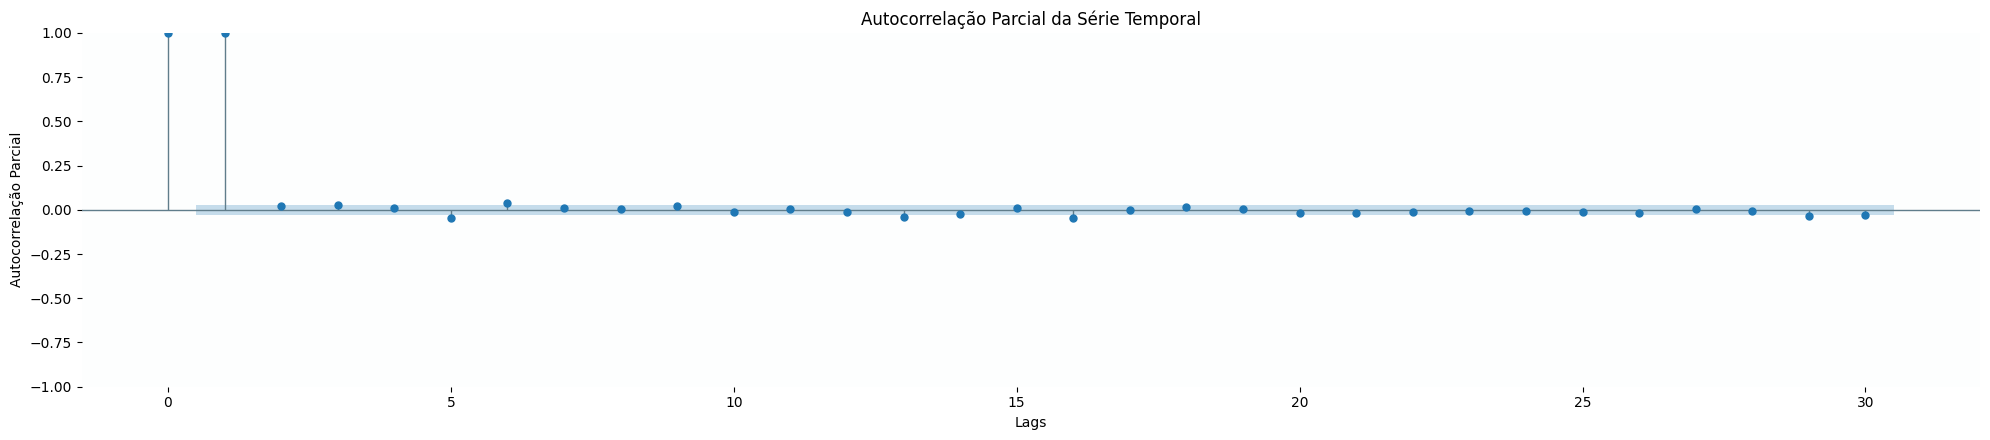

In [75]:
# @title
# acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf


def plot_pacf(df, lags=30, title="Autocorrela√ß√£o Parcial da S√©rie Temporal"):

    fig, ax = plt.subplots(figsize=(20, 4.5))
    # Get the ACF values and confidence intervals
    _plot_pacf(df, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrela√ß√£o Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(df, alpha=0.05, nlags=30)
    # acf_x = sm.tsa.pacf(df, alpha=0.05, nlags=3) #com 3 dias j√° √© possivel identificar o PACF
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes PACF interceptam o limiar no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes PACF n√£o interceptam o limiar")

plot_pacf(df["fechamento"])

**Gr√°fico 15:** Autocorrela√ß√£o Parcial da S√©rie Temporal do Brent com lag 2 (2007 - 2025)

### 1.4 Estacionariedade


**O que √©:** Uma s√©rie temporal √© considerada estacion√°ria quando possui   propriedade   estat√≠sticas  razoavelmente est√°veis ao longo do tempo (no que se diz sobre m√©dia e √† vari√¢ncia).

**Resultado:** Ao longo da An√°lise Explorat√≥ria dos Dados a s√©rie temporal apresentou caracteristicas n√£o estacionar√°rias. O teste ADF (valor-p = 0,15) confirmou essa caracter√≠stica, evidenciando a necessidade de transforma√ß√£o (diferencia√ß√£o) da s√©rie para garantir a estacionariedade e permitir uma modelagem mais precisa.

In [76]:
# @title
# Executar o teste de Dickey-Fuller Aumentado (ADF)
adf_result = sm.tsa.adfuller(df["fechamento"])

# Organizar os resultados em um DataFrame
adf_table = pd.DataFrame({
    "M√©trica": ["Estat√≠stica ADF", "Valor-p", "Valor Cr√≠tico 1%", "Valor Cr√≠tico 5%", "Valor Cr√≠tico 10%"],
    "Valor": [round(adf_result[0], 2), round(adf_result[1], 2),
              round(adf_result[4]['1%'], 2), round(adf_result[4]['5%'], 2),
              round(adf_result[4]['10%'], 2)]
})

# Exibir a tabela formatada
print(adf_table.to_string(index=False))

# Verificar se a s√©rie √© estacion√°ria
if adf_result[1] < 0.05:
    print("\nA s√©rie temporal √© estacion√°ria")
else:
    print("\nA s√©rie temporal n√£o √© estacion√°ria")


          M√©trica  Valor
  Estat√≠stica ADF  -2.36
          Valor-p   0.15
 Valor Cr√≠tico 1%  -3.43
 Valor Cr√≠tico 5%  -2.86
Valor Cr√≠tico 10%  -2.57

A s√©rie temporal n√£o √© estacion√°ria


## 2. Prepara√ß√£o dos Dados para Modelagem


### 2.1 Diferencia√ß√£o para estacionariedade

A fim de garantir a qualidade das an√°lises e previs√µes, a s√©rie temporal foi transformada em estacion√°ria por meio da diferencia√ß√£o. Essa etapa √© fundamental para remover componentes n√£o estacion√°rios, como tend√™ncias e sazonalidades, que podem prejudicar a modelagem.

In [77]:
# @title
# Diferenciar a s√©rie uma vez e remover valores NaN
df_diff = df["fechamento"].diff().dropna()

# Executar o teste de Dickey-Fuller Aumentado (ADF) na s√©rie diferenciada
adf_result = sm.tsa.adfuller(df_diff)

# Organizar os resultados em um DataFrame
adf_table = pd.DataFrame({
    "M√©trica": ["Estat√≠stica ADF", "Valor-p", "Valor Cr√≠tico 1%", "Valor Cr√≠tico 5%", "Valor Cr√≠tico 10%"],
    "Valor": [round(adf_result[0], 2), round(adf_result[1], 2),
              round(adf_result[4]['1%'], 2), round(adf_result[4]['5%'], 2),
              round(adf_result[4]['10%'], 2)]
})

# Exibir a tabela formatada
print(adf_table.to_string(index=False))

# Verificar se a s√©rie diferenciada √© estacion√°ria
if adf_result[1] < 0.05:
    print("\nA s√©rie temporal diferenciada √© estacion√°ria")
else:
    print("\nA s√©rie temporal diferenciada n√£o √© estacion√°ria")


          M√©trica  Valor
  Estat√≠stica ADF -15.76
          Valor-p   0.00
 Valor Cr√≠tico 1%  -3.43
 Valor Cr√≠tico 5%  -2.86
Valor Cr√≠tico 10%  -2.57

A s√©rie temporal diferenciada √© estacion√°ria


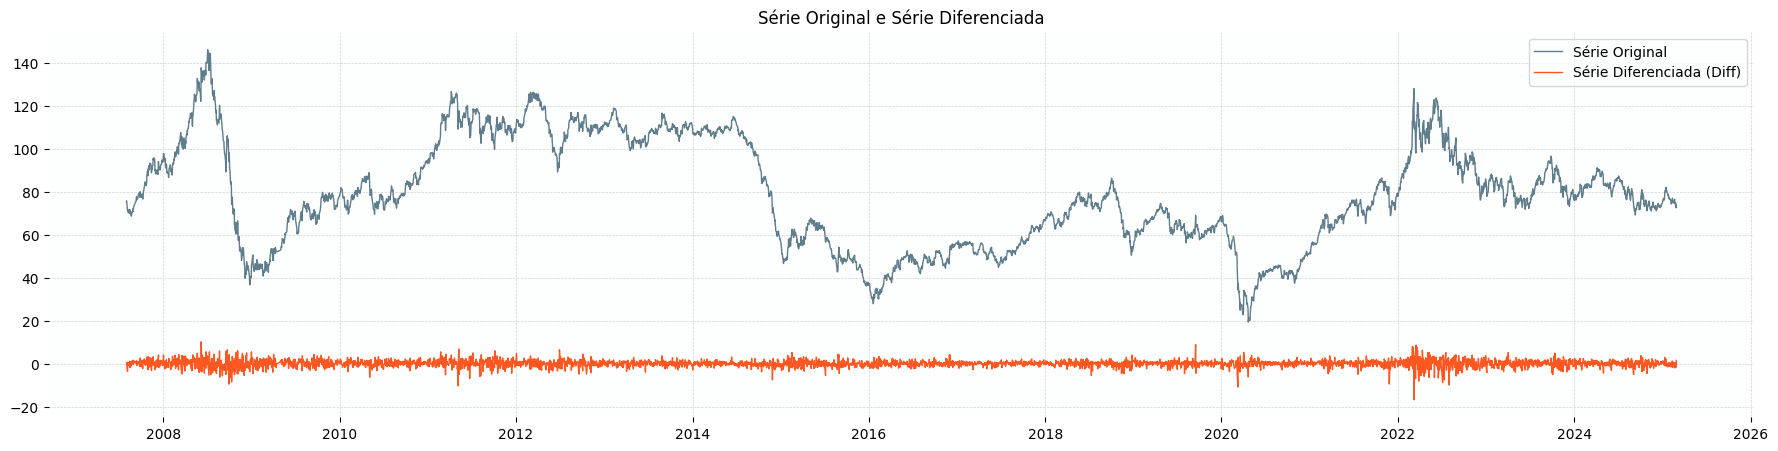

In [78]:
# @title
import matplotlib.pyplot as plt

# S√©rie original
fig, ax = plt.subplots(figsize=(22, 5))

# Plotar a s√©rie original
ax.plot(df["fechamento"], color='#607d8b', label="S√©rie Original")

# Aplicar a transforma√ß√£o de diferen√ßa (diff)
df_diff = df["fechamento"].diff().dropna()

# Plotar a s√©rie diferenciada no mesmo gr√°fico
ax.plot(df_diff, color='#ff5722', label="S√©rie Diferenciada (Diff)")

# Adicionar t√≠tulo e legenda
ax.set_title("S√©rie Original e S√©rie Diferenciada")
ax.legend()

# Exibir o gr√°fico
plt.grid(True)
plt.show()


**Gr√°fico 16:** Transforma√ß√£o para Estacionariedade: Compara√ß√£o entre a s√©rie original n√£o estacion√°ria e a s√©rie diferenciada, estacion√°ria, obtida por meio da primeira diferen√ßa.

A estacionariedade da s√©rie, confirmada pelo teste ADF e Gr√°fico 16, permite dar prosseguimento √† pr√≥xima etapa que consiste em identificar os par√¢metros mais adequados para os modelo, a fim de capturar a din√¢mica da s√©rie e gerar previs√µes precisas.

### 2.2 Par√¢metros para Modelagem

#### Coeficientes de autoregress√£o (ARIMA)

**Resultado foi obtido:** (2, 1, 227)

Uma vez que a s√©rie temporal √© estacionaria √© poss√≠vel obter os coeficientes de regress√£o : p, d e q. Esses coeficientes s√£o essenciais para construir um modelo ARIMA adequado, que consiga capturar as din√¢micas da s√©rie temporal de forma eficaz, permitindo previs√µes mais precisas.


* ACF √© usada para determinar o par√¢metro ùëû, identificando a ordem da parte de m√©dias m√≥veis do modelo.
* PACF √© usada para determinar o par√¢metro ùëù, identificando a ordem da parte autoregressiva do modelo.
*ùëë foi previamente identificado como o n√∫mero de diferencia√ß√µes necess√°rias para tornar a s√©rie estacion√°ria.



In [79]:
# @title
acf_x = sm.tsa.acf(df["fechamento"], alpha=0.05, nlags=500) #consigo apartir de 227
acf, ci = acf_x[:2]
# identifica√ß√£o do q pelo ponto de intercepta√ß√£o ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df["fechamento"], alpha=0.05, nlags=30) #apartir de 2 dias
pacf, ci = pacf_x[:2]
# identifica√ß√£o do p pelo ponto de intercepta√ß√£o ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferencia√ß√£o foi necess√°ria para tornar a s√©rie estacion√°ria

#parametros do modelo ARIMA (autorregressivel com a m√©dia m√≥vel)

print("Valor de p:", p)
print("Valor de d:", d)
print("Valor de q:", q)


Valor de p: 2
Valor de d: 1
Valor de q: 227


#### Determinando os par√¢metros de sazonalidade (SARIMA)

**Melhor modelo:** ARIMA(3,1,2)(1,0,0)[12]


Para determinar os par√¢metros de sazonalidade, foi utilizada a fun√ß√£o model = pm.auto_arima. O resultado obtido foi:

**Melhor modelo:** SARIMA(3,1,2)(1,0,0,12)[12]

Esse modelo (1, 0, 0, 12) indica um ciclo sazonal de 12 meses, mas n√£o leva em conta a autocorrela√ß√£o ou a m√©dia m√≥vel sazonal. Essa configura√ß√£o sugere que a s√©rie temporal apresenta um padr√£o sazonal regular, sem complexidades adicionais.


In [80]:
# @title
model = pm.auto_arima(
    df["fechamento"],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
)

# Summary of the model's detected parameters
print(model.summary())

# Detected seasonal order
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=16888.320, Time=25.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16896.591, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=16890.503, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=16890.526, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16894.591, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=16887.766, Time=7.07 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=16890.507, Time=3.11 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=16888.797, Time=18.47 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=16887.590, Time=11.65 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=16888.663, Time=22.98 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=16890.290, Time=34.90 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=16894.303, Time=2.09 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=16890.267, Time=4.05 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=16877.571, Time=6.83 sec


### 2.3 Dividindo os Dados em Treino e Teste
Para avaliar a performance do modelo, os dados foram divididos em conjuntos de treinamento (70%) e teste (30%). O modelo foi treinado com o conjunto de treino e, em seguida, avaliado com o conjunto de teste.

In [81]:
# @title
# Dividindo em treino e teste
train_size = int(df.shape[0] * 0.7)  # 70% dos dados para treino
train, test = df[:train_size], df[train_size:]

# Prepara√ß√£o dos dados para XGBoost (usando a data do √≠ndice)
def create_features(modelo_df):
    modelo_df = modelo_df.copy()  # Evitar altera√ß√µes na vers√£o original
    modelo_df["year"] = modelo_df.index.year
    modelo_df["month"] = modelo_df.index.month
    modelo_df["day"] = modelo_df.index.day
    modelo_df["dayofweek"] = modelo_df.index.dayofweek
    return modelo_df

train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "abertura"]  # Inclua m√©dia m√≥vel para aumentar a precis√£o
TARGET = "fechamento"


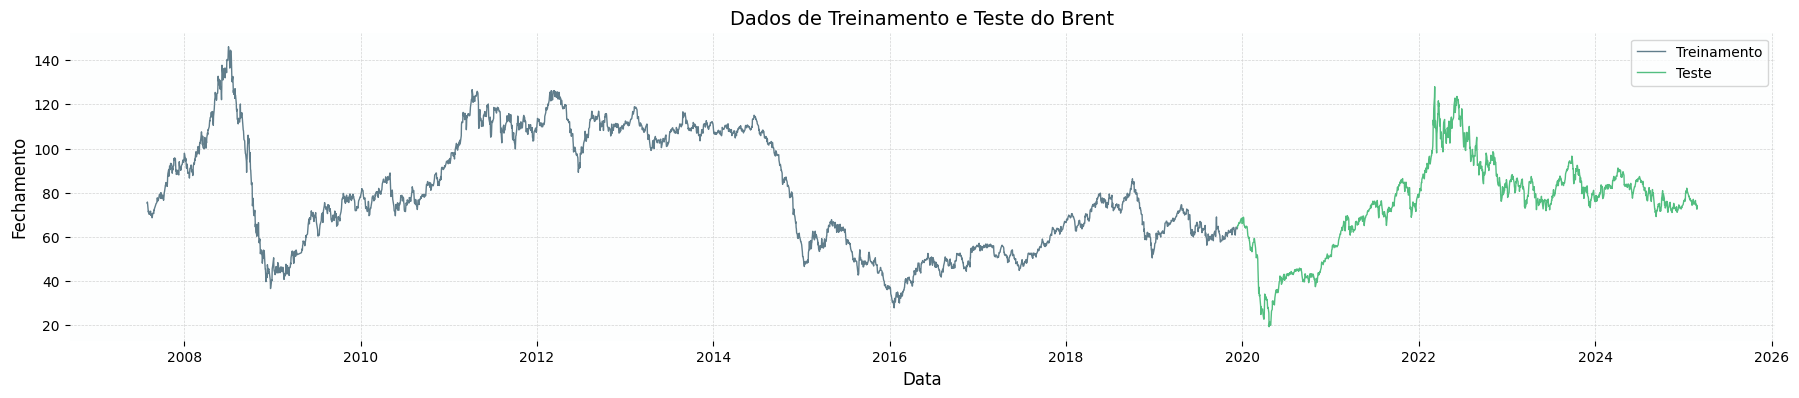

In [82]:
# @title
# Configura√ß√µes do gr√°fico
plt.figure(figsize=(22, 4))
plt.gca().set_facecolor('#fdfefe')
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Plotando os dados de treino e teste
plt.plot(train.index, train['fechamento'], color='#607d8b', linewidth=1, label='Treinamento')
plt.plot(test.index, test['fechamento'], color='#52be80', linewidth=1, label='Teste')

# Configura√ß√µes dos r√≥tulos e t√≠tulo
plt.xlabel('Data', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)
plt.title('Dados de Treinamento e Teste do Brent', fontsize=14)
plt.legend()

# Exibindo o gr√°fico
plt.show()


**Gr√°fico 17:** Divis√£o dos Dados do Brent: Treino e Teste.

## 3. Modelagem

Ap√≥s a prepara√ß√£o dos dados, ser√° realizada a escolha do modelo de previs√£o, que √© crucial para obter previs√µes precisas. Tr√™s modelos de aprendizado ser√£o testados com dados de treinamento e teste, e o desempenho ser√° avaliado pelo MAPE (Mean Absolute Percentage Error) para identificar o ajuste mais adequado aos dados do Brent.


> O MAPE mostra o quanto, em m√©dia, as previs√µes de um modelo est√£o erradas em rela√ß√£o aos valores reais, expressando esse erro em porcentagem. Logo, **quanto menor o MAPE melhor**.



### 3.1 Modelo XGBoost

**O que √©:** O XGBoost √© um algoritmo de machine learning baseado em boosting de √°rvores de decis√£o, conhecido por seu alto desempenho, mas suscet√≠vel a overfitting e menos adequado para s√©ries temporais que requerem m√©dias m√≥veis, como em s√©ries temporais financeiras.

**Resultado:** XGBoost teve um MAPE de 2.64%.


**Observa√ß√µes:** Este modelo demonstra excelente precis√£o (97,36%) na previs√£o dos pre√ßos do Brent. Observa-se um ajuste muito pr√≥ximo entre as linhas de previs√£o (laranja) e dados reais (azul) ao longo de todo o per√≠odo 2020-2025. O modelo captura com efici√™ncia tanto os picos quanto as quedas bruscas, incluindo a queda hist√≥rica durante a pandemia em 2020. √â not√°vel como as previs√µes acompanham precisamente at√© mesmo as pequenas flutua√ß√µes di√°rias.

In [83]:
# @title
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avalia√ß√£o XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 1.5832083125812249
MSE: 5.4108420147725536
MAPE: 2.64 %


In [84]:
print("Acur√°cia:", f"{100 - 2.64: .2f}%")

Acur√°cia:  97.36%


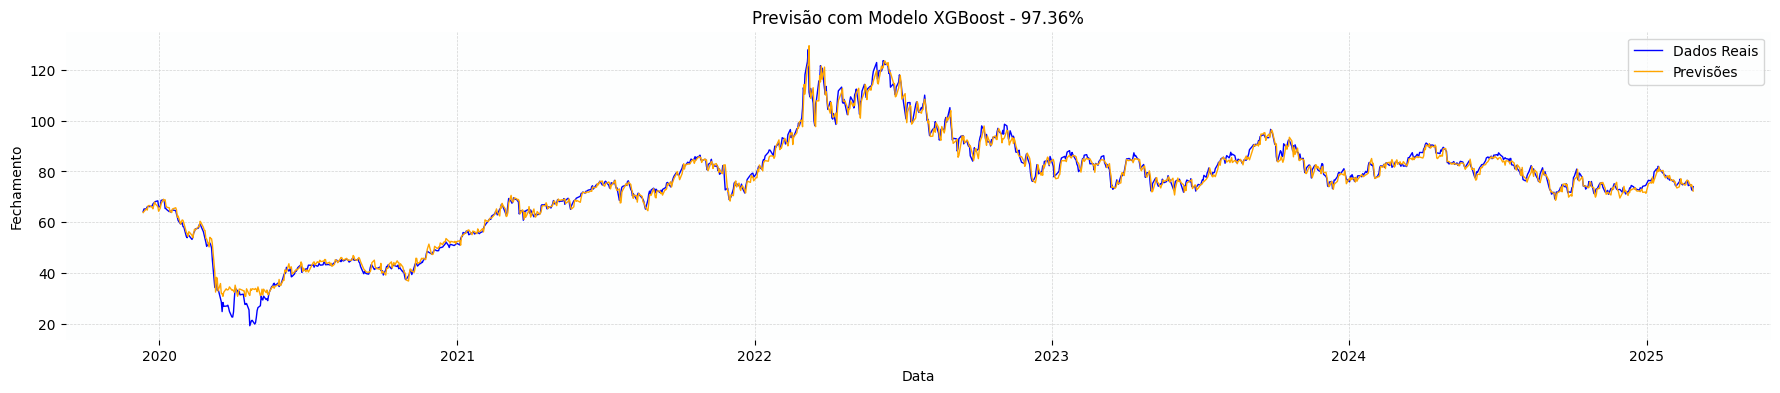

In [85]:
# @title
# Plotar resultados
plt.figure(figsize=(22, 4))
plt.plot(test.index, y_test, label='Dados Reais', color='blue', linewidth=1)  # Linha real
plt.plot(test.index, preds, label='Previs√µes', color='orange', linewidth=1)  # Previs√µes
plt.title('Previs√£o com Modelo XGBoost - 97.36%')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid()
plt.show()



**Gr√°fico 18:** Desempenho do Modelo XGBoost. O gr√°fico mostra uma compara√ß√£o entre os dados reais do Brent (em azul) e as previs√µes geradas por um modelo XGBoost (em laranja) ao longo do tempo.

### 3.2 Modelo Prophet

**O que √©:** O Prophet √© um modelo de previs√£o de s√©ries temporais, desenvolvido pelo Facebook, que lida bem com tend√™ncias e sazonalidades. Ele utiliza m√©dias m√≥veis e suaviza√ß√£o exponencial para ajustar tend√™ncias de longo prazo, capturando varia√ß√µes sazonais e eventos externos, sendo eficaz em dados financeiros complexos.


**Resultado:** O Prophet teve um MAPE de 20.35 %.


**Observa√ß√µes:** Este modelo apresenta a menor precis√£o (79,65%) entre os tr√™s. Diferentemente dos outros, o Prophet mostra um intervalo de confian√ßa (√°rea cinza) e cobre um per√≠odo hist√≥rico mais longo (desde 2008). Observa-se que as previs√µes come√ßam apenas em 2020, e h√° diverg√™ncias significativas em alguns per√≠odos, especialmente em 2023-2024, onde o modelo n√£o captura adequadamente algumas oscila√ß√µes de pre√ßo.

In [86]:
# @title
# Ajustando os dados para Prophet
train_prophet = train.rename(columns={"fechamento": "y"}).copy()
train_prophet["ds"] = train_prophet.index

test_prophet = test.rename(columns={"fechamento": "y"}).copy()
test_prophet["ds"] = test_prophet.index

# Criando o modelo Prophet
model = Prophet(daily_seasonality=True)
model.add_regressor("abertura")
model.fit(train_prophet)

# Criando datas futuras para a previs√£o
future = model.make_future_dataframe(periods=len(test))
future = future.set_index("ds").join(pd.concat([train, test])["abertura"]).reset_index()

# Preenchendo valores ausentes de "abertura"
future["abertura"] = future["abertura"].ffill()

# Fazendo previs√£o
forecast = model.predict(future)

# Preparando os dados para avalia√ß√£o
preds = forecast[["ds", "yhat"]].set_index("ds").tail(len(test))
y_test = test_prophet.set_index("ds")["y"]

# Calculando m√©tricas
metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("\nProphet Metrics:")
print_metrics(metrics_pr)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpdel6w_l4/c17tb2iy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdel6w_l4/u4osm2k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99725', 'data', 'file=/tmp/tmpdel6w_l4/c17tb2iy.json', 'init=/tmp/tmpdel6w_l4/u4osm2k7.json', 'output', 'file=/tmp/tmpdel6w_l4/prophet_model6prtwvzc/prophet_model-20250304020054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Metrics:
MAE: 14.749836402334529
MSE: 358.9347409005401
MAPE: 20.35 %


In [87]:
print("Acur√°cia:", f"{100 - 20.35: .2f}%")

Acur√°cia:  79.65%


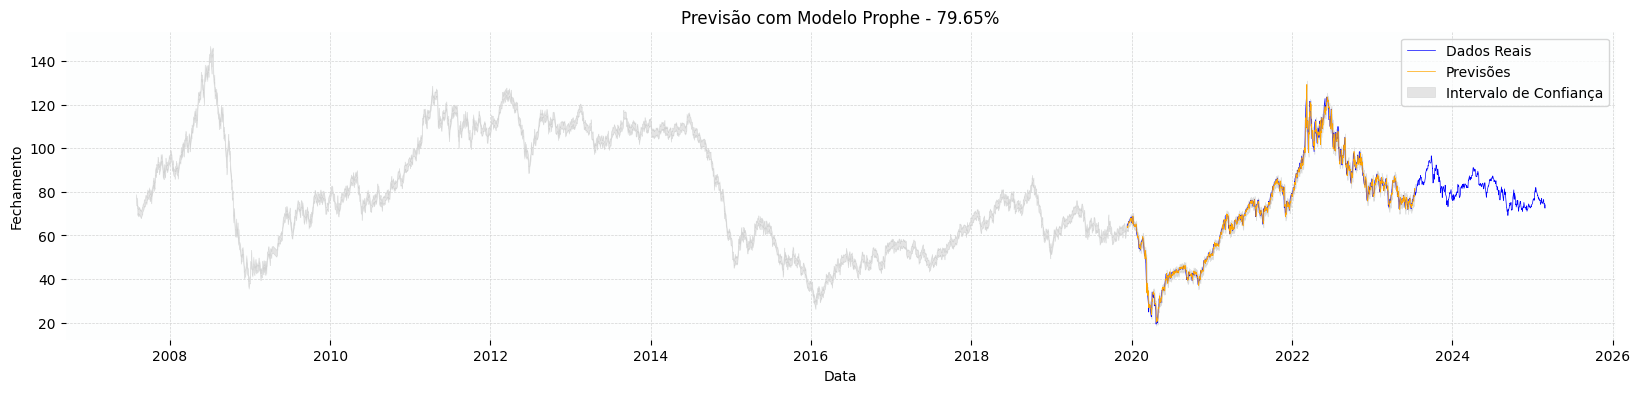

In [88]:
# @title
# Plotar resultados do modelo prophet
plt.figure(figsize=(20, 4))
plt.plot(y_test.index, y_test, label='Dados Reais', color='blue', linewidth=0.5)  # Linha fina
plt.plot(preds.index, preds['yhat'], label='Previs√µes', color='orange', linewidth=0.5)  # Linha fina
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Intervalo de Confian√ßa', linewidth=0.5)
plt.title('Previs√£o com Modelo Prophe - 79.65%')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid()
plt.show()

**Gr√°fico 18:** Desempenho do Modelo Prophet. O gr√°fico apresenta a previs√£o do modelo Prophet aplicado √† s√©rie temporal do Brent, comparando dados reais (linha azul) com as previs√µes do modelo (linha laranja) e o intervalo de confian√ßa (√°rea cinza).



### 3.3 Modelo SARIMAX

**O que √©:** O SARIMAX √© um modelo de s√©ries temporais que integra autoregress√£o, m√©dias m√≥veis, sazonalidade e vari√°veis ex√≥genas, sendo especialmente √∫til para dados financeiros com padr√µes sazonais e influenciados por fatores externos, como taxas de juros e indicadores econ√¥micos.


**Resultado:** O SARIMAX teve um MAPE de 1.73 %.


**Observa√ß√µes:** Este modelo apresenta a maior precis√£o entre os tr√™s (98,27%). As linhas de previs√£o e valores reais praticamente se sobrep√µem, tornando dif√≠cil distinguir uma da outra em v√°rios trechos. O SARIMAX captura com excel√™ncia os movimentos de alta volatilidade (como o pico de 2022) e tamb√©m os per√≠odos de tend√™ncia. O ajuste √© excepcionalmente bom em todo o intervalo temporal analisado.

In [89]:
p, d, q

(2, 1, 227)

In [90]:
# @title
# Modelo SARIMAX
exog_train = train[["abertura"]]
exog_test = test[["abertura"]]

model = sm.tsa.statespace.SARIMAX(
    train["abertura"],
    exog=exog_train,
    order=(
        p,
        d,
        10,
    ),  # q muito grande faz com que o modelo fique muito complexo e lento
    seasonal_order=(1, 0, 0, 12),
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["fechamento"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 1.2281504296386694
MSE: 3.124917408120124
MAPE: 1.73 %


In [91]:
print("Acur√°cia:", f"{100 - 1.73: .2f}%")

Acur√°cia:  98.27%


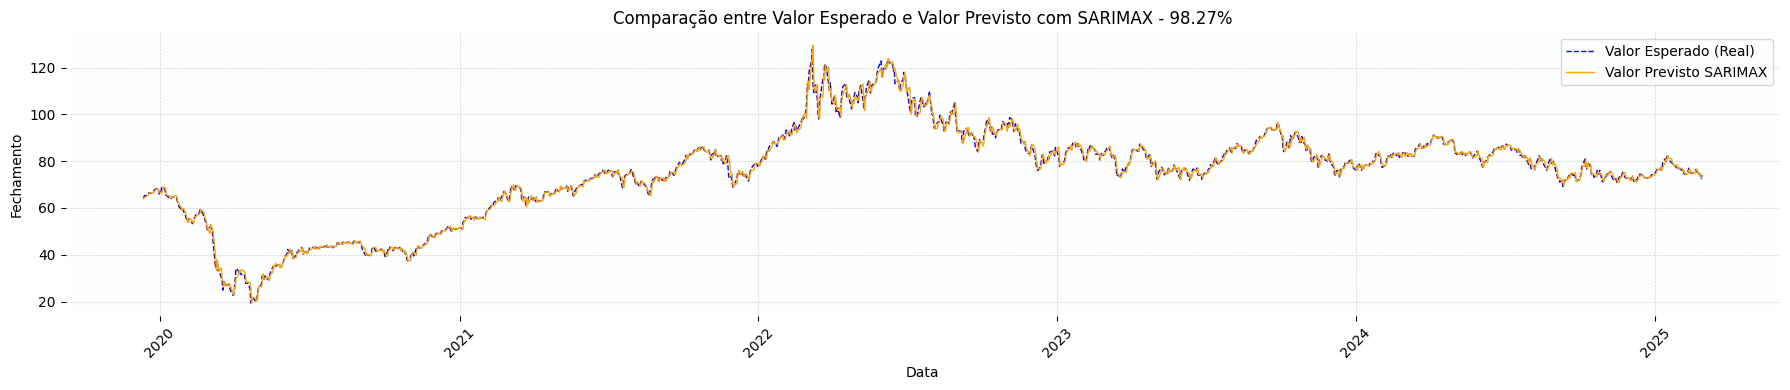

In [92]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

# Plotando os resultados
plt.figure(figsize=(18, 4))
plt.plot(test.index, test["fechamento"], label='Valor Esperado (Real)', color='blue', linestyle='--')
plt.plot(test.index, preds, label='Valor Previsto SARIMAX', color='orange')
plt.title('Compara√ß√£o entre Valor Esperado e Valor Previsto com SARIMAX - 98.27%')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para melhor legibilidade
plt.grid()
plt.tight_layout()
plt.show()


**Gr√°fico 19:** Desempenho do Modelo SARIMAX. O gr√°fico apresenta a previs√£o do modelo SARIMAX aplicado √† s√©rie temporal do Brent, comparando dados reais (linha azul) com as previs√µes do modelo (linha laranja).

## Conclus√£o

In [93]:
# @title
# Criar DataFrame com as m√©tricas
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)

# Calcular a acur√°cia e adicionar como nova coluna
df["Acur√°cia (%)"] = 100 - df["MAPE"]

# Ordenar DataFrame pela coluna MAPE
df_sorted = df.sort_values(by="MAPE", ascending=True)

# Estilizar a tabela
styled_df = df_sorted.style.format({
    "MAE": "{:.2f}",
    "MSE": "{:.2e}",
    "MAPE": "{:.6f}",
    "Acur√°cia (%)": "{:.2f}"
}).set_caption("Compara√ß√£o de Modelos")

# Exibir a tabela estilizada (no Jupyter Notebook, use styled_df)
styled_df


Para avaliar a precis√£o das previs√µes, tr√™s modelos foram comparados: SARIMAX, Prophet e XGBoost. Utilizando o erro percentual m√©dio absoluto (MAPE) como m√©trica, o SARIMAX apresentou o melhor desempenho, com um MAPE de 1,74%. O XGBoost, com um MAPE de 2,64%, tamb√©m demonstrou bons resultados. J√° o Prophet, com um MAPE significativamente maior (20,35%), mostrou dificuldades em capturar as nuances dos dados da s√©rie do Brent.

Diante dos resultados, o modelo SARIMAX se mostrou o mais adequado para prever o comportamento complexo do Brent pelos seguintes motivos:

1. Apresenta a maior precis√£o (98,27%) entre os tr√™s modelos analisados.
2. Captura com excel√™ncia tanto tend√™ncias quanto flutua√ß√µes de curto prazo
3. Seu desempenho √© consistente ao longo de todo o per√≠odo analisado
4. Alinha-se com a caracter√≠stica de autocorrela√ß√£o do Brent identificada anteriormente, onde os coeficientes PACF indicavam a import√¢ncia dos lags mais recentes, enquanto o ACF mostrava persist√™ncia - caracter√≠sticas que o SARIMAX √© especialmente projetado para modelar atrav√©s de seus componentes sazonal e autorregressivo
5. √â particularmente adequado para s√©ries temporais com potenciais componentes sazonais, como o mercado de petr√≥leo que pode sofrer influ√™ncias c√≠clicas de fatores econ√¥micos e geopol√≠ticos.
6. Apesar do XGBoost apresentar resultado muito pr√≥ximo o SARIMAX demonstra ligeira superioridade na precis√£o e maior adequa√ß√£o conceitual √† estrutura temporal identificada na s√©rie do Brent.

## Baixar Modelo SARIMAX

In [94]:
import joblib
from google.colab import files

# Salvar o modelo
joblib.dump(results, 'sarimax_model.pkl')


# Baixar o modelo
files.download('sarimax_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>